In [1]:
import datetime
import numpy as np
import pandas as pd
import sqlalchemy as sa
import sqlalchemy.types
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from sqlalchemy.engine import reflection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
connection_string = 'DRIVER={ODBC Driver 17 for sql server};SERVER=BI-SQL;DATABASE=ZSDBillingDoc_BillingItm;UID=sa;PWD=1qazXSW@'

connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})

engine = create_engine(connection_url,pool_size=10, max_overflow=20)

In [3]:
%%time
with engine.begin() as conn:
    df = pd.read_sql_query(sa.text("SELECT LEFT([DOCDATE], 6) AS DocMonth,[SALEORG], SUM(CASE WHEN [ITMWEIGHTUNI] = 'G' THEN [ITMNETWEIGHT] / 1000 ELSE [ITMNETWEIGHT] END * CASE WHEN [RETRNITMTYPE] = 'X' THEN -1 ELSE 1 END) AS AdjustedWeight FROM [ZSDBillingDoc_BillingItm].[dbo].[/BIC/OHZSDBILMHB] GROUP BY LEFT([DOCDATE], 6),[SALEORG]"), conn)

CPU times: total: 15.6 ms
Wall time: 9.95 s


In [4]:
conn.close()

In [5]:
df.to_csv(r"C:\Users\b-jafari.ZARMACARON\Notebooks\Data\Data-PLANT02.CSV")

In [6]:
df = pd.read_csv(r"C:\Users\b-jafari.ZARMACARON\Notebooks\Data\Data-PLANT02.CSV")

In [7]:
df.head(5)

Unnamed: 0  DocMonth  SALEORG  AdjustedWeight
0           0    202109     5070      422945.030
1           1    202306     5020      496587.864
2           2    202004     5010     1400419.940
3           3    202005     5100      217429.560
4           4    202006     5050      240440.340

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows',10,'display.max_columns', 20)


In [9]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [10]:
df['DocMonth'] = pd.to_datetime(df['DocMonth'].astype(str), format='%Y%m')  
df['YearMonth'] = df['DocMonth'].dt.to_period('M')  



In [11]:
df = df[df['YearMonth'].dt.year != 1762]


In [12]:
asd=df[df['YearMonth']==pd.Period('2024-10')]
dft=df[df['YearMonth'] < pd.Period('2024-10')]

In [13]:
dft['ds'] = dft['YearMonth'].dt.to_timestamp()
dft['branch']=dft['SALEORG']
dft['y'] = dft['AdjustedWeight']
dft = dft[['ds', 'y','branch']]

C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_34448\256625741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['ds'] = dft['YearMonth'].dt.to_timestamp()
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_34448\256625741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['branch']=dft['SALEORG']
C:\Users\b-jafari.ZARMACARON\AppData\Local\Temp\2\ipykernel_34448\256625741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [14]:
dft

ds          y  branch
0    2021-09-01  422945.03    5070
1    2023-06-01  496587.86    5020
2    2020-04-01 1400419.94    5010
3    2020-05-01  217429.56    5100
4    2020-06-01  240440.34    5050
...         ...        ...     ...
1961 2024-02-01       0.00    1031
1962 2021-07-01  594248.93    7100
1963 2022-08-01    4750.50    5290
1964 2023-11-01   16420.71    5341
1965 2021-01-01 5340669.50    1001

[1784 rows x 3 columns]

In [15]:
from prophet import Prophet

model = Prophet()
model.add_regressor('branch')
model.fit(dft)


09:28:24 - cmdstanpy - INFO - Chain [1] start processing
09:28:24 - cmdstanpy - INFO - Chain [1] done processing


In [16]:




future = model.make_future_dataframe(periods=2, freq='M')  

branch_values = [5010, 5110, 5120, 5040, 5330, 5070, 5160, 5111, 5020, 5082, 5050,
       5310, 5030, 5181, 5001, 5101, 5080, 1001, 1020, 1000, 1010, 1002,
       1030, 5060, 5081, 5021, 5130, 5320, 5190, 1011, 7100, 5090, 5102,
       5170, 5290, 5100, 5150, 5360, 5300, 1021, 1031, 5180, 5350, 5341,
       7700, 5140, 5340, 1006, 4001, 5370, 1101]

future['branch'] = branch_values * (len(future) // len(branch_values)) + branch_values[:len(future) % len(branch_values)]

forecast = model.predict(future)


09:28:24 - cmdstanpy - INFO - Chain [1] start processing
09:28:25 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

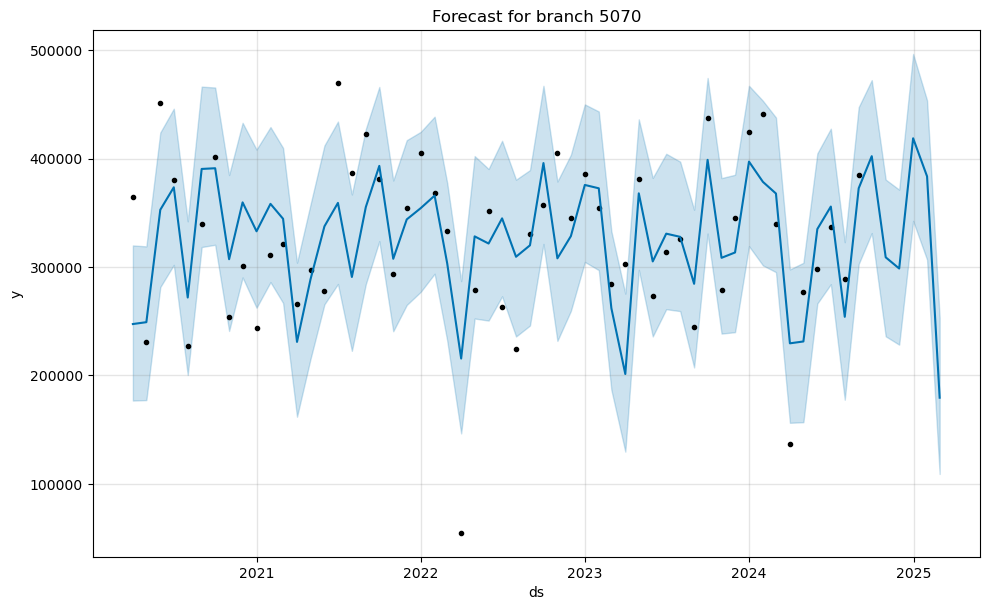

09:28:25 - cmdstanpy - INFO - Chain [1] start processing
09:28:25 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

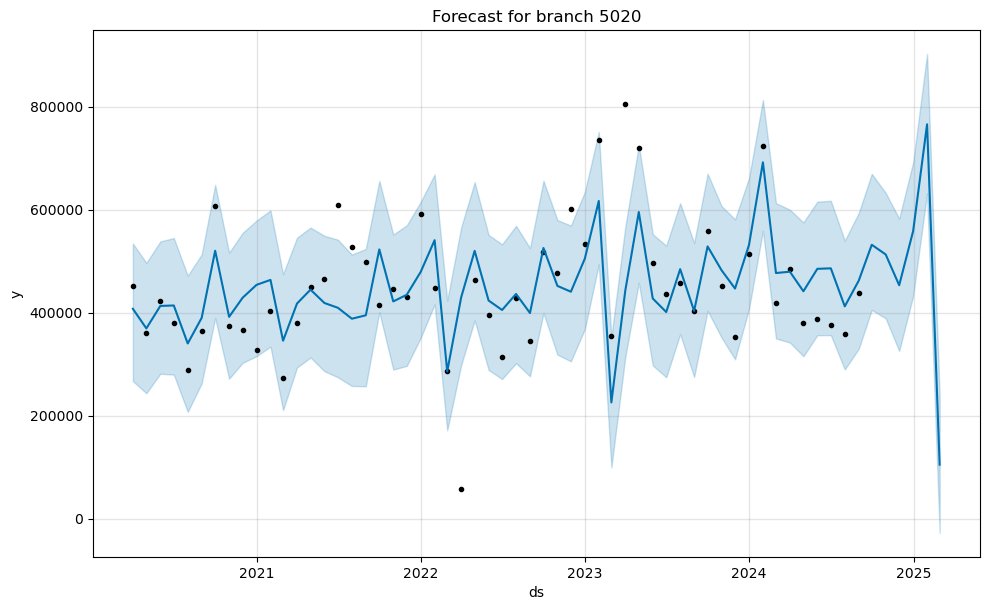

09:28:26 - cmdstanpy - INFO - Chain [1] start processing
09:28:26 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

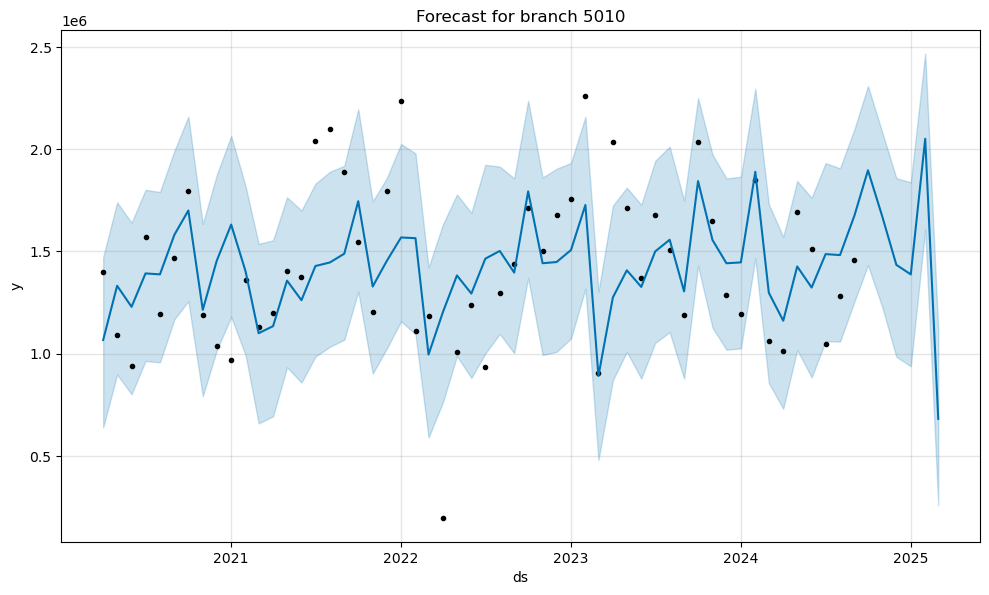

09:28:27 - cmdstanpy - INFO - Chain [1] start processing
09:28:27 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

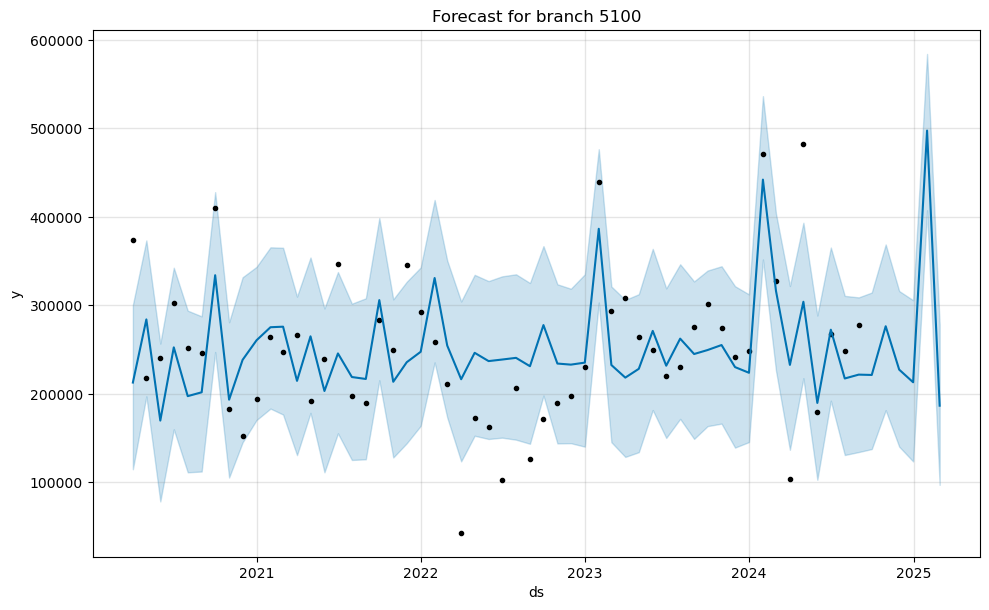

09:28:27 - cmdstanpy - INFO - Chain [1] start processing
09:28:28 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

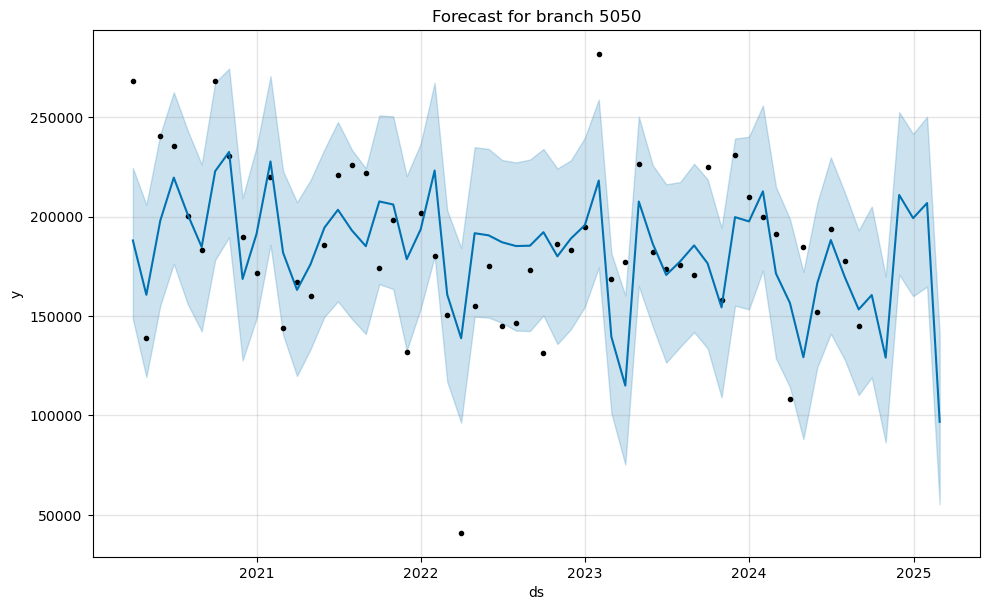

09:28:28 - cmdstanpy - INFO - Chain [1] start processing
09:28:28 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

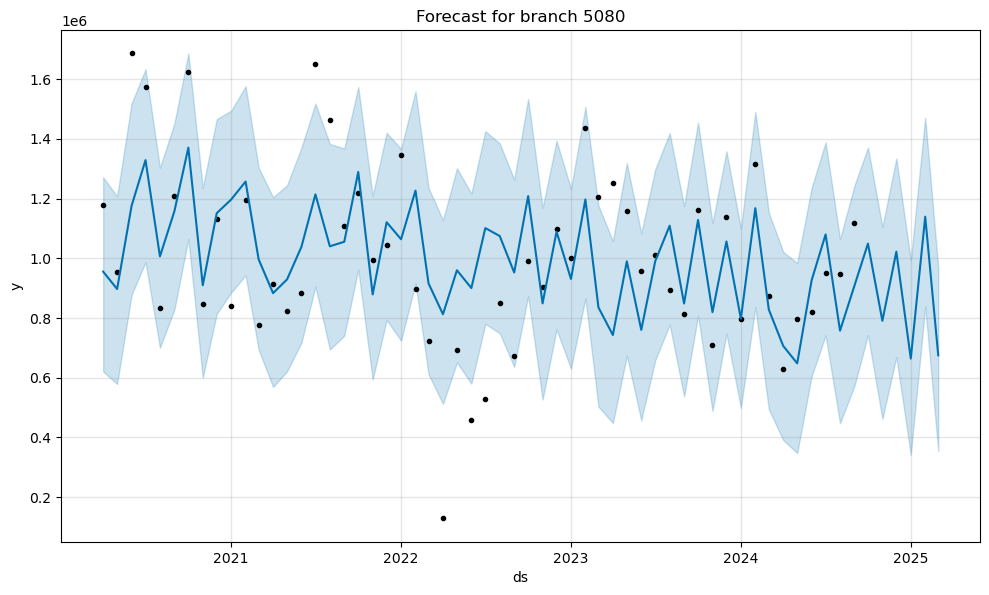

09:28:29 - cmdstanpy - INFO - Chain [1] start processing
09:28:29 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

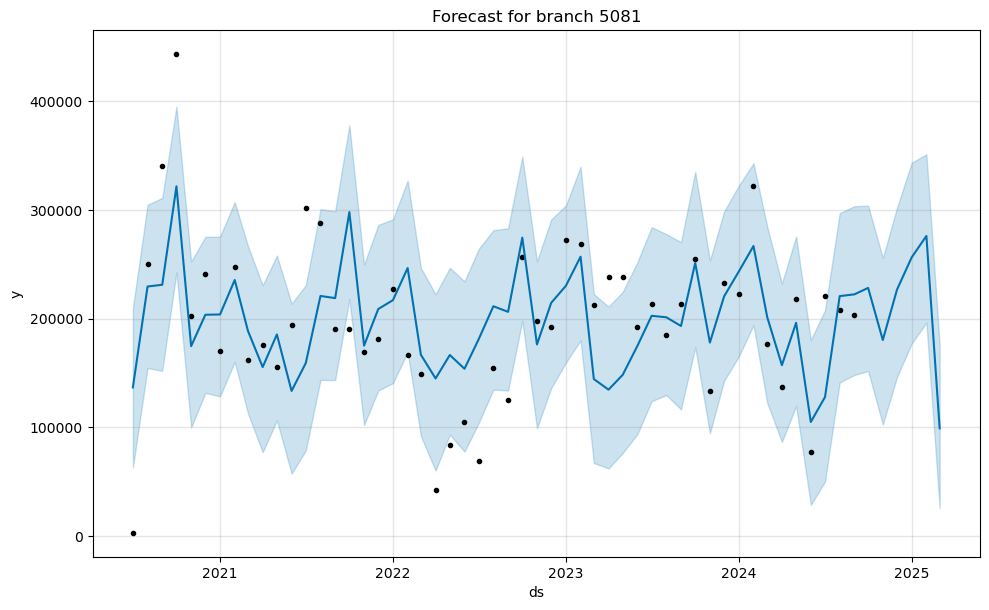

09:28:30 - cmdstanpy - INFO - Chain [1] start processing
09:28:30 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

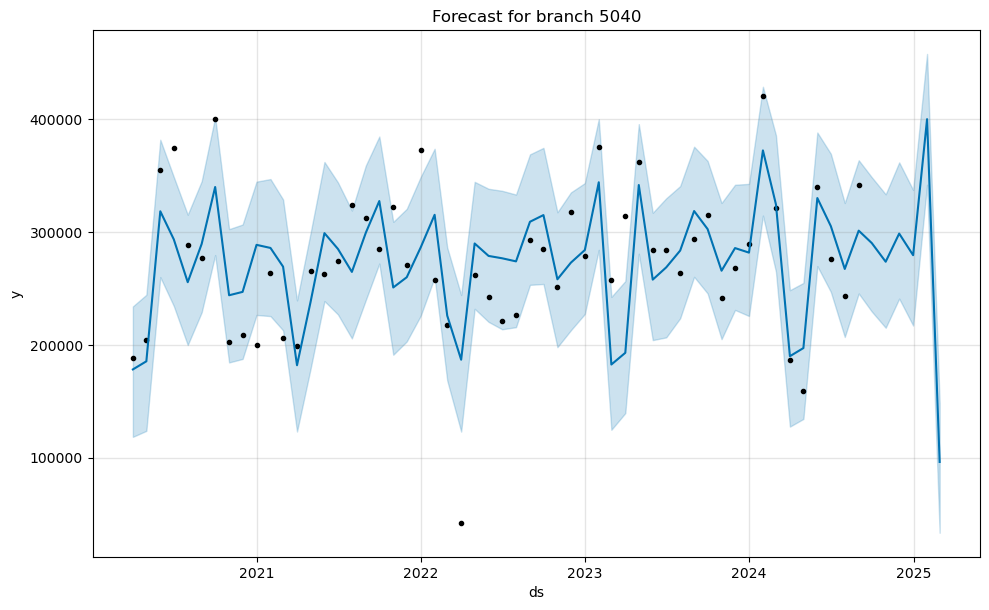

09:28:30 - cmdstanpy - INFO - Chain [1] start processing
09:28:30 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

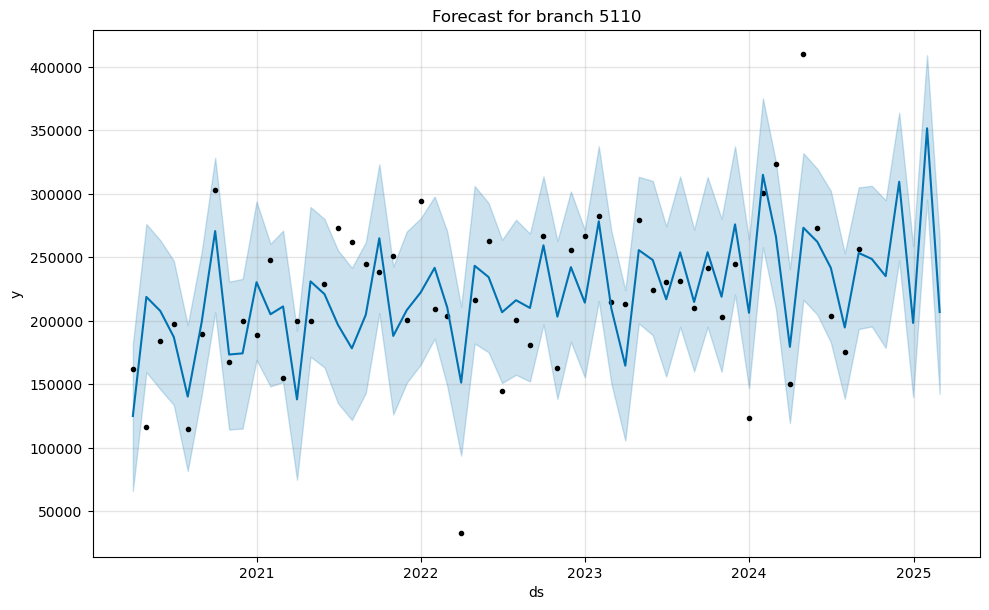

09:28:31 - cmdstanpy - INFO - Chain [1] start processing
09:28:31 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

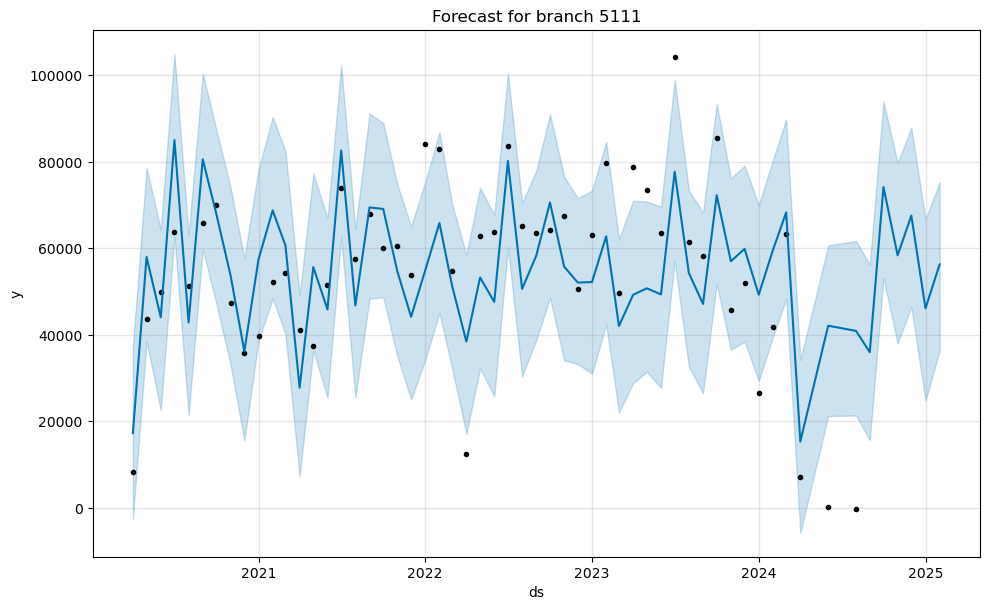

09:28:32 - cmdstanpy - INFO - Chain [1] start processing
09:28:32 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

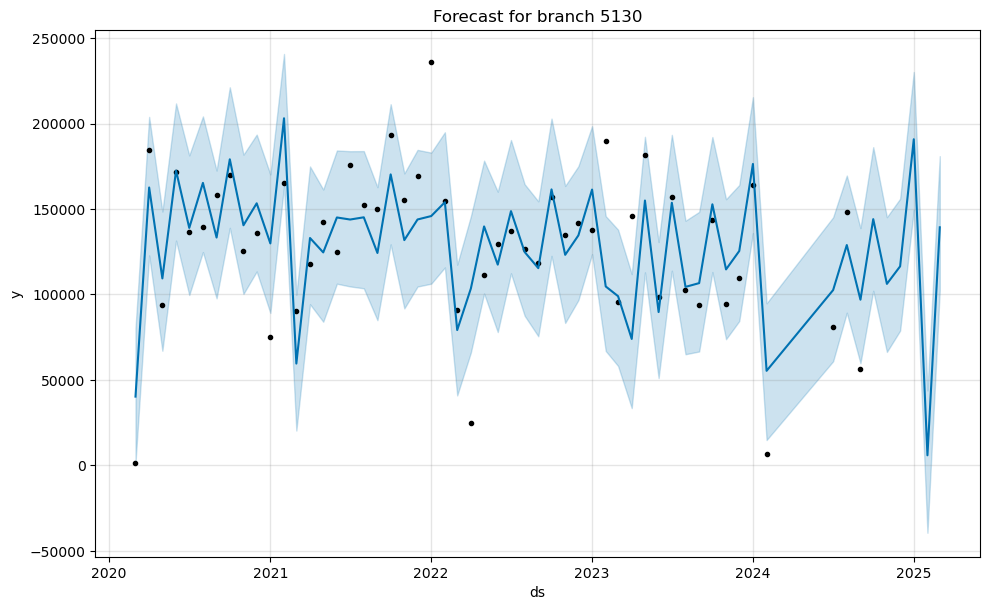

09:28:33 - cmdstanpy - INFO - Chain [1] start processing
09:28:33 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

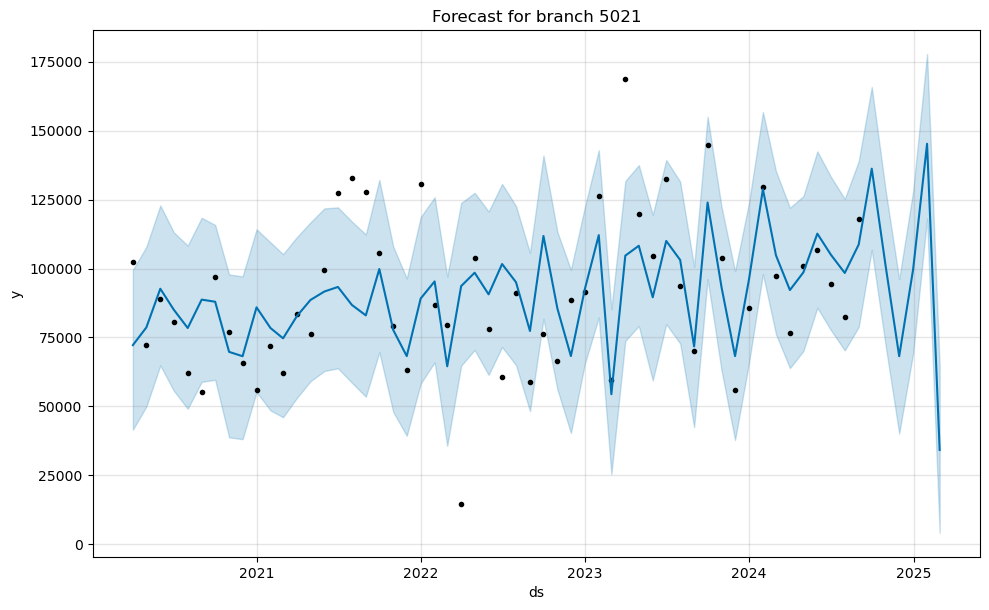

09:28:33 - cmdstanpy - INFO - Chain [1] start processing
09:28:33 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

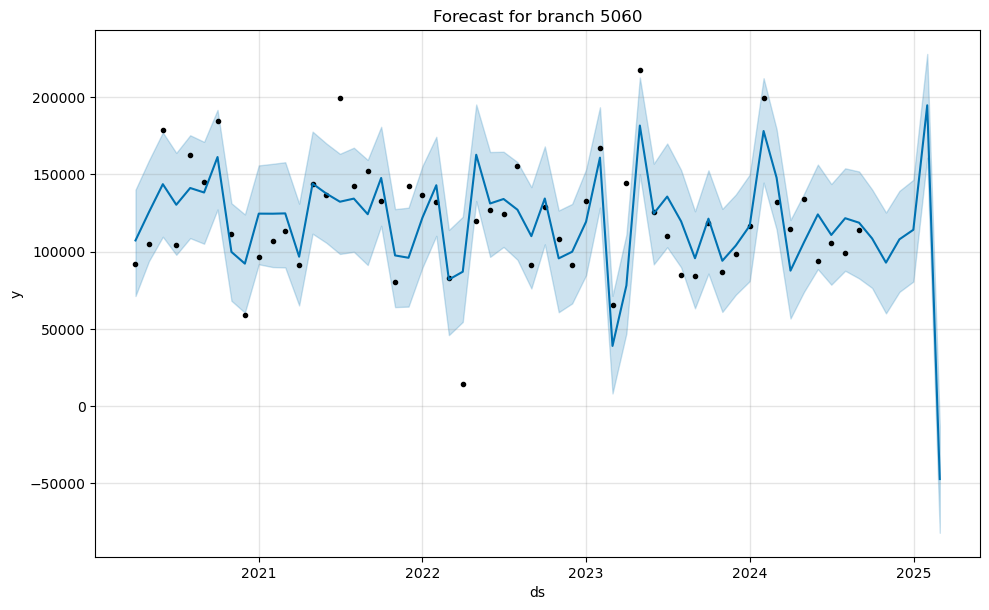

09:28:34 - cmdstanpy - INFO - Chain [1] start processing
09:28:34 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

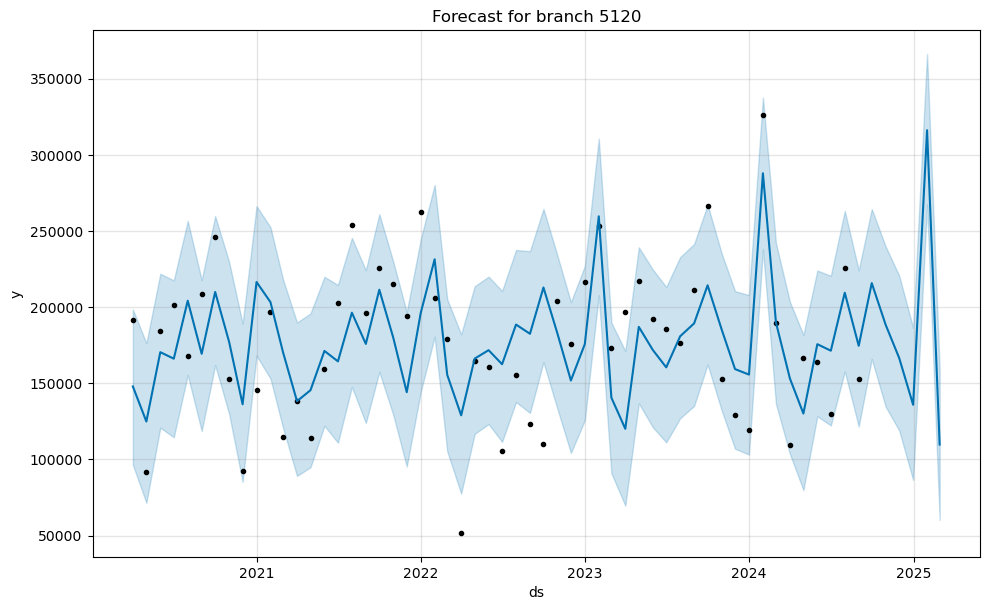

09:28:34 - cmdstanpy - INFO - Chain [1] start processing
09:28:35 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

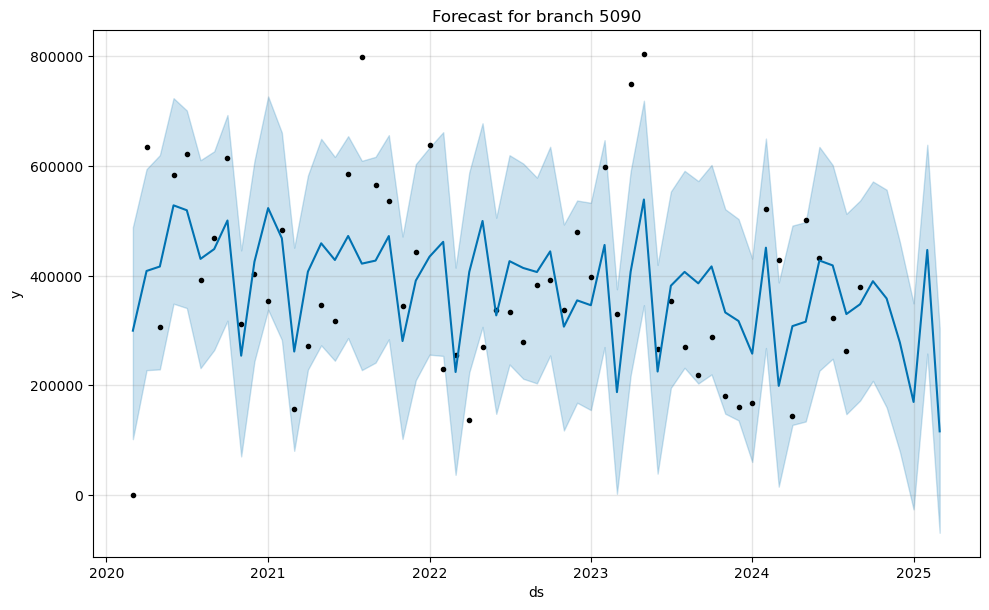

09:28:35 - cmdstanpy - INFO - Chain [1] start processing
09:28:35 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

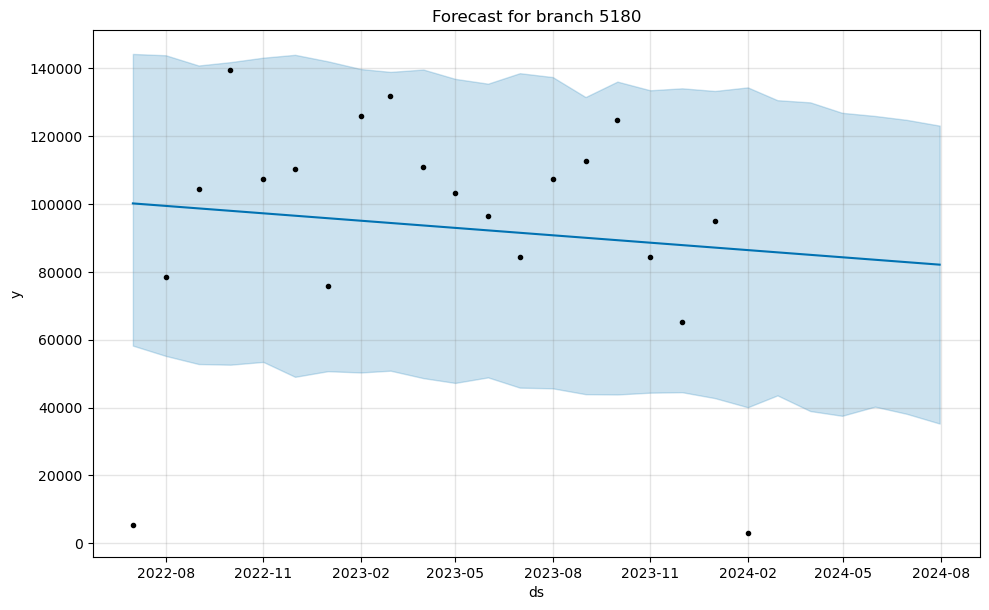

09:28:36 - cmdstanpy - INFO - Chain [1] start processing
09:28:36 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

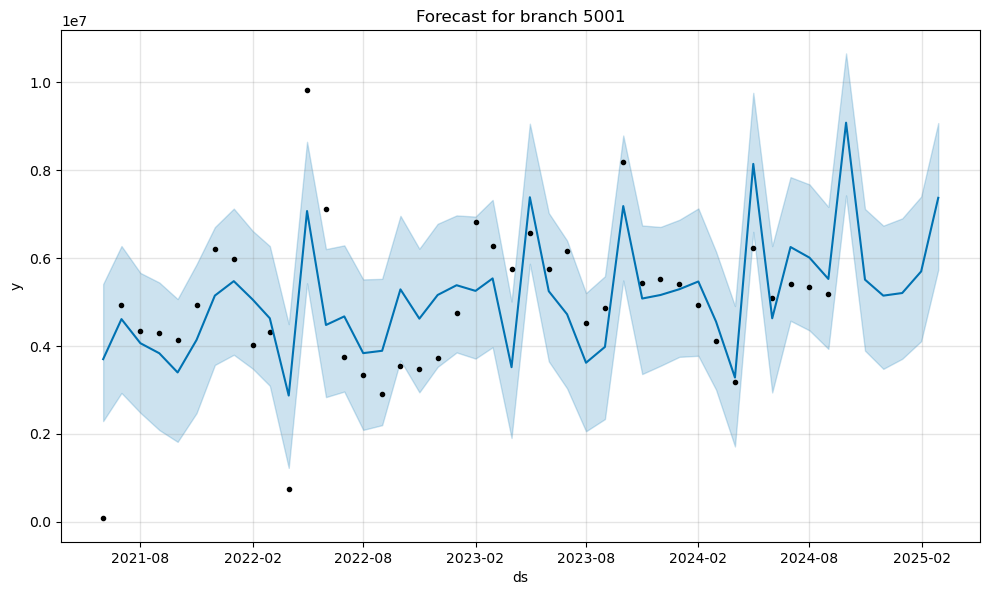

09:28:36 - cmdstanpy - INFO - Chain [1] start processing
09:28:37 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

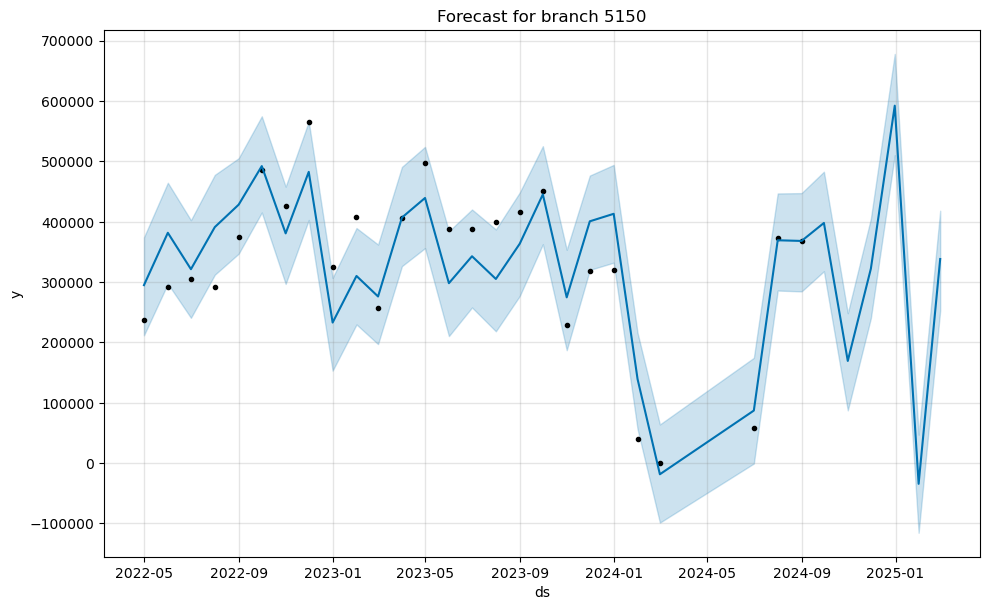

09:28:37 - cmdstanpy - INFO - Chain [1] start processing
09:28:37 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

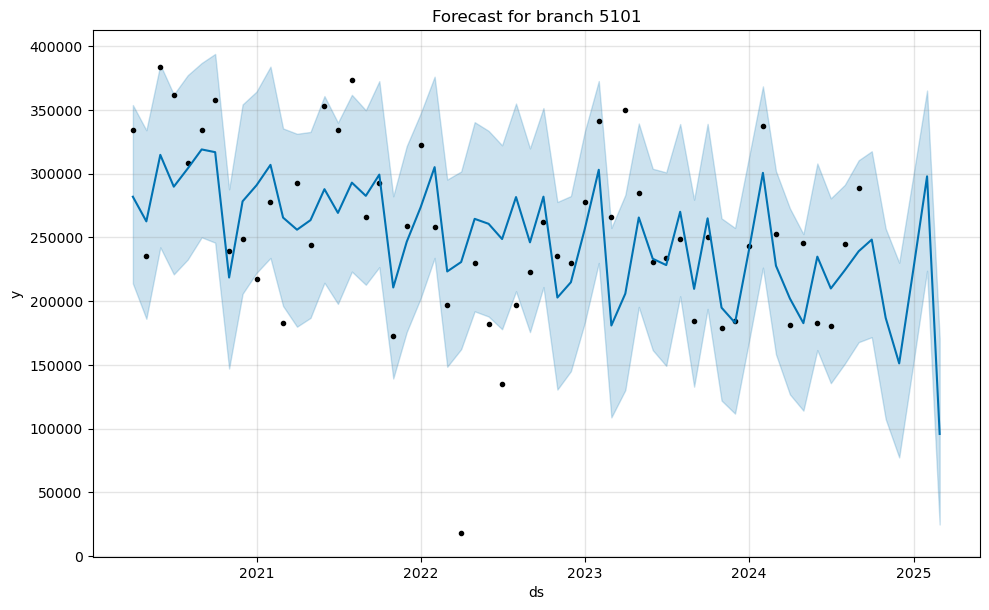

09:28:38 - cmdstanpy - INFO - Chain [1] start processing
09:28:38 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

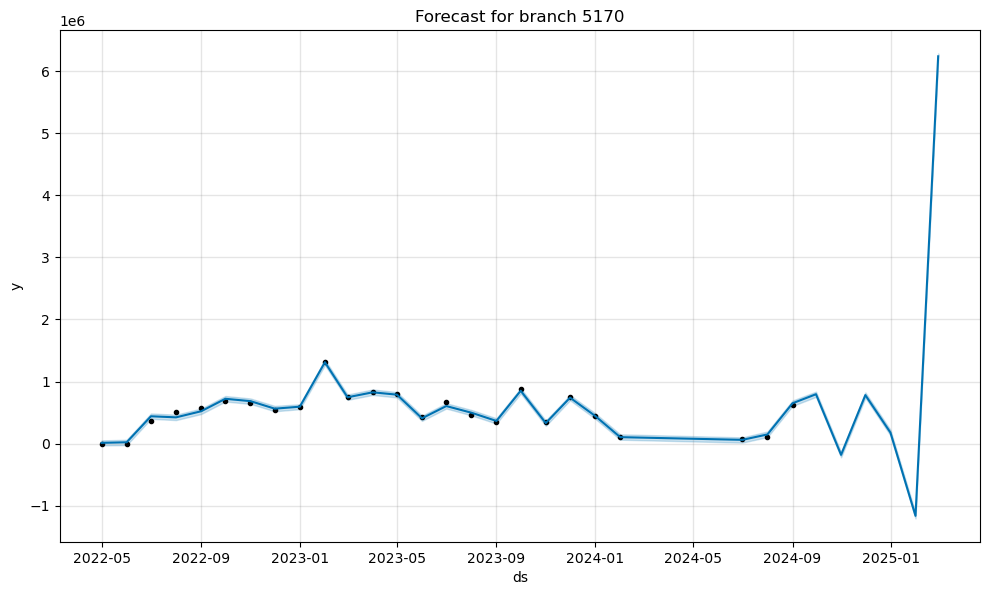

09:28:39 - cmdstanpy - INFO - Chain [1] start processing
09:28:39 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

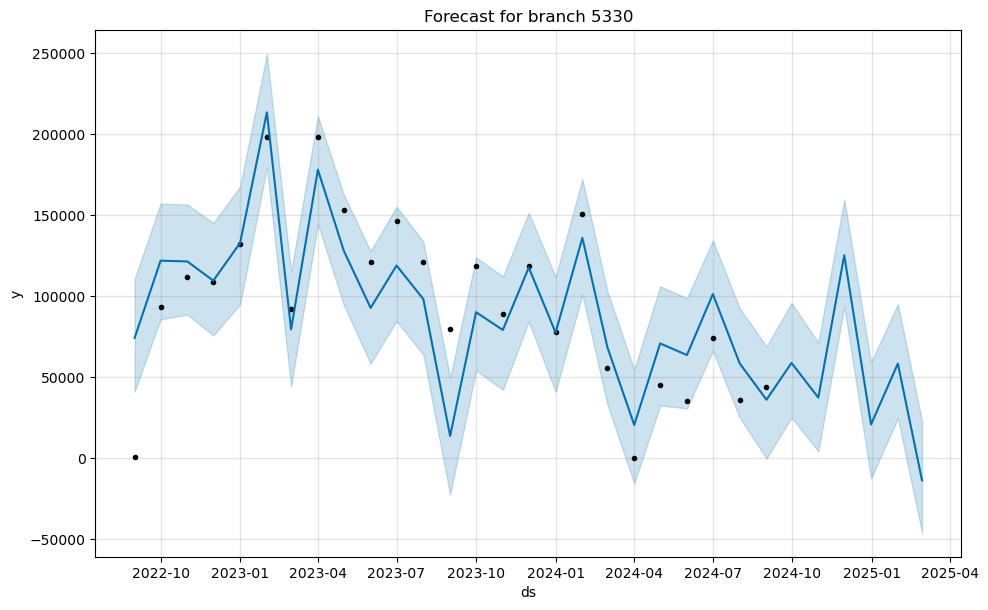

09:28:39 - cmdstanpy - INFO - Chain [1] start processing
09:28:39 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

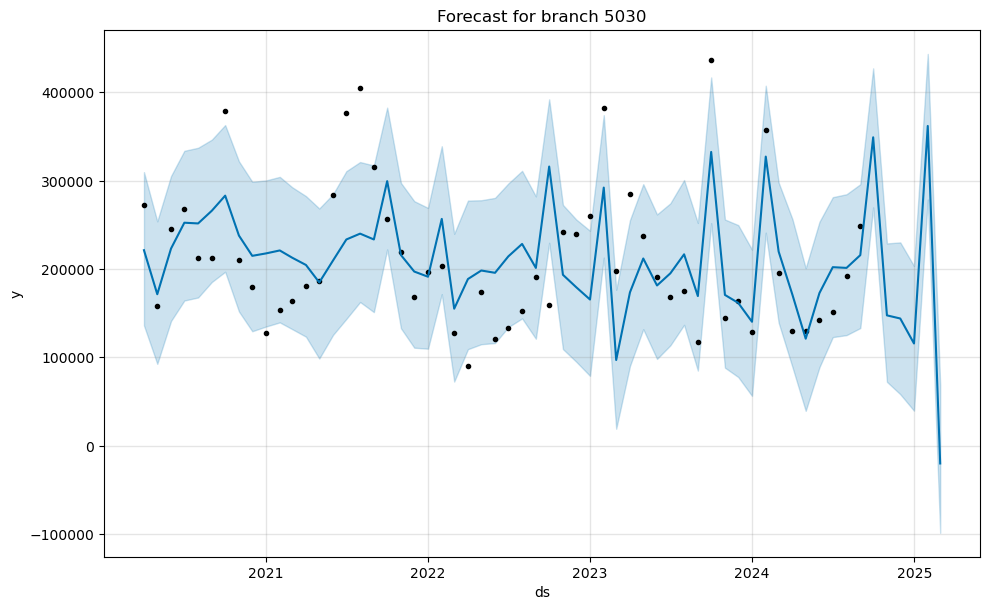

09:28:40 - cmdstanpy - INFO - Chain [1] start processing
09:28:40 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

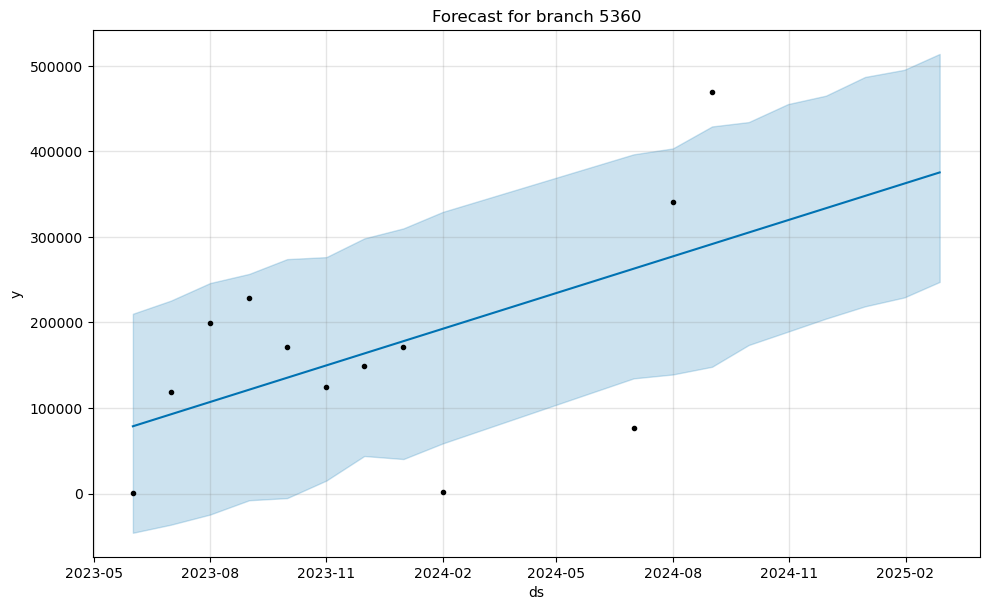

09:28:41 - cmdstanpy - INFO - Chain [1] start processing
09:28:41 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

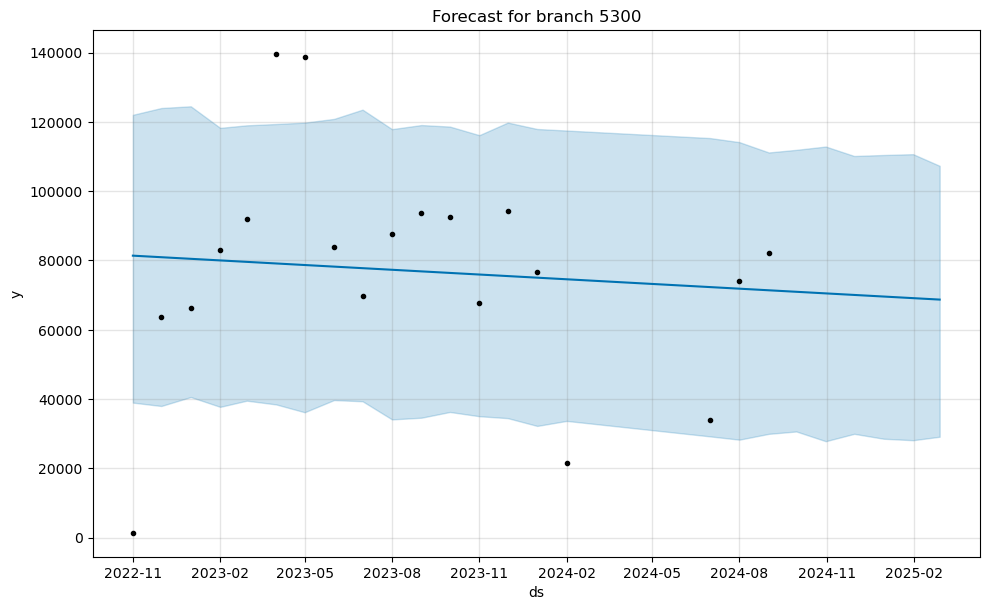

09:28:41 - cmdstanpy - INFO - Chain [1] start processing
09:28:41 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

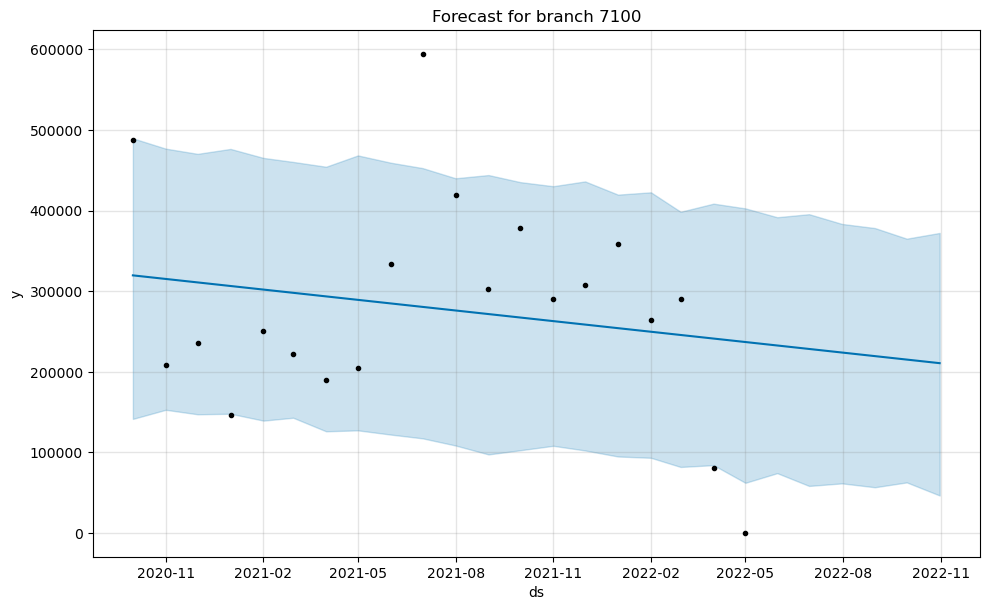

09:28:42 - cmdstanpy - INFO - Chain [1] start processing
09:28:42 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

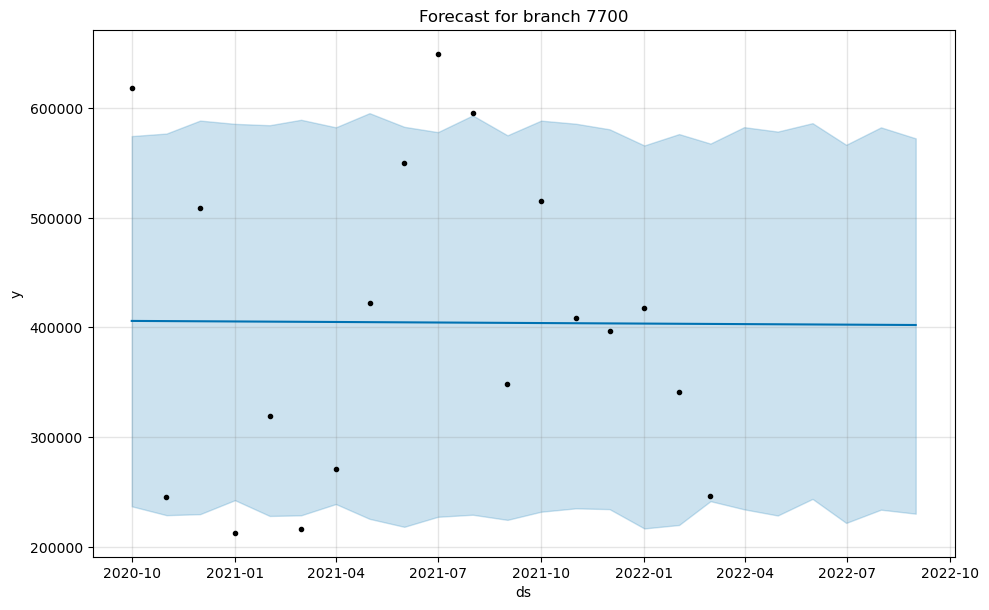

09:28:42 - cmdstanpy - INFO - Chain [1] start processing
09:28:42 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

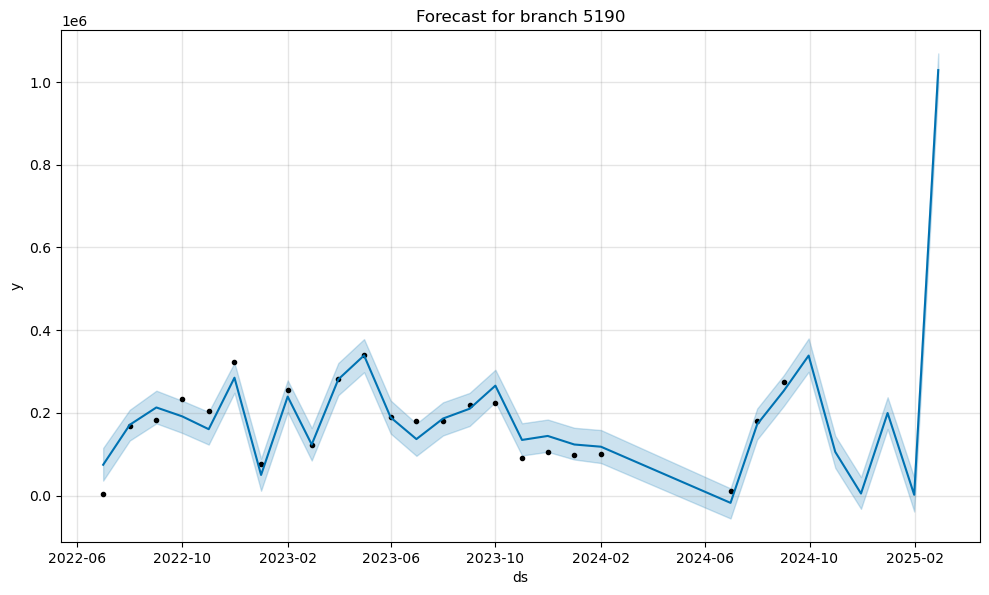

09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

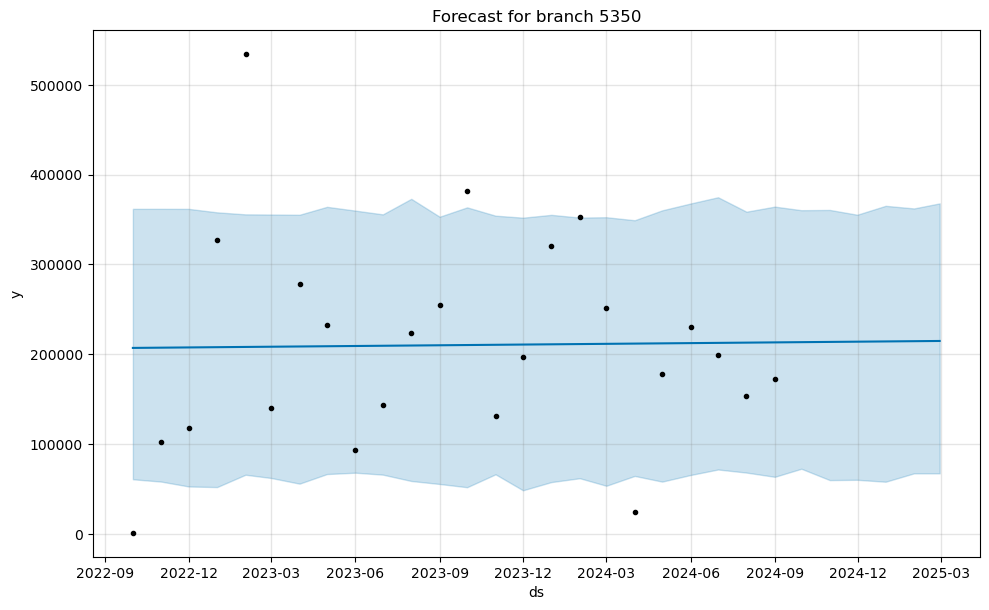

09:28:43 - cmdstanpy - INFO - Chain [1] start processing
09:28:43 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

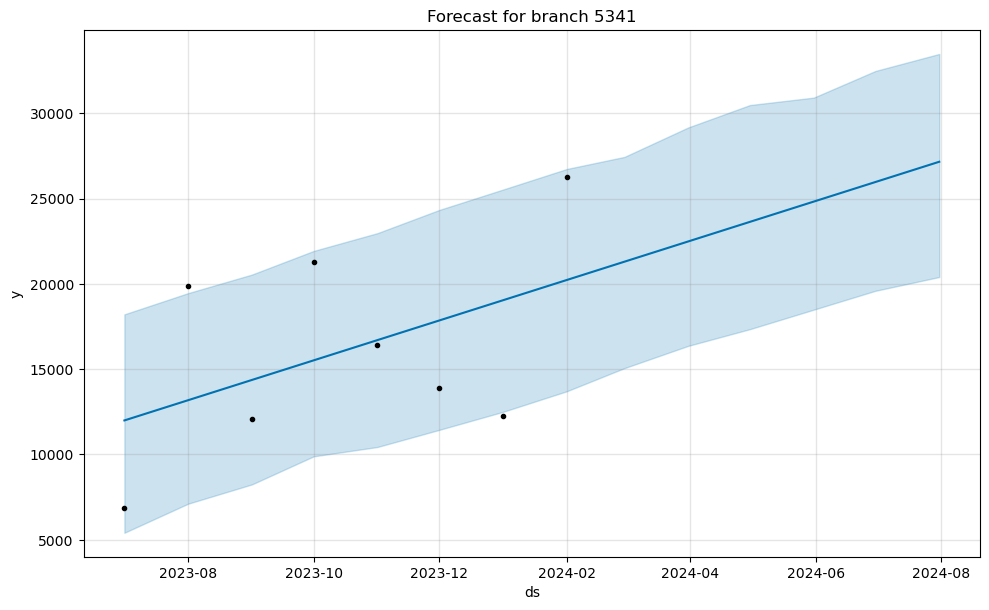

09:28:44 - cmdstanpy - INFO - Chain [1] start processing
09:28:44 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

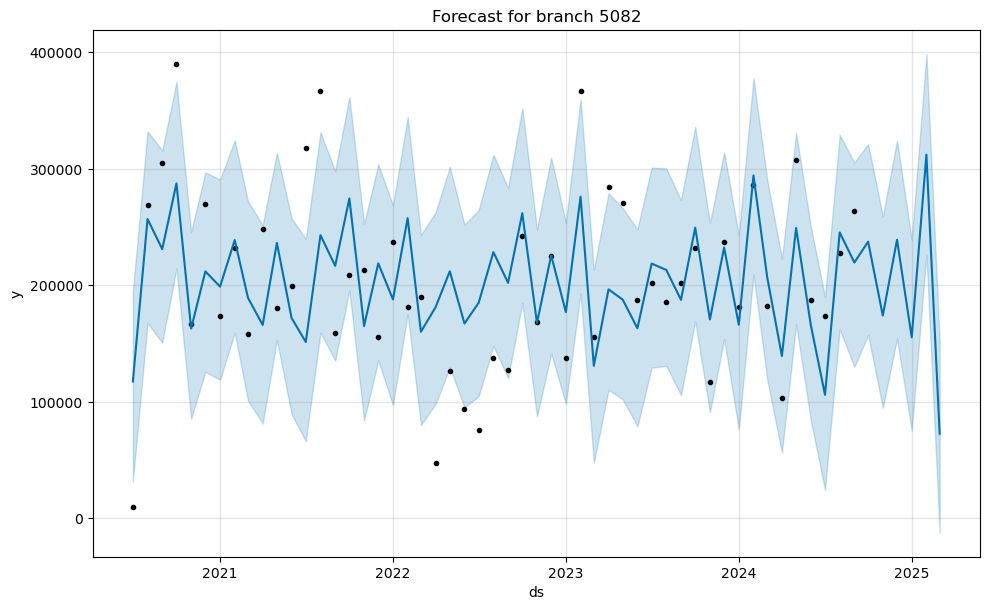

09:28:45 - cmdstanpy - INFO - Chain [1] start processing
09:28:45 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

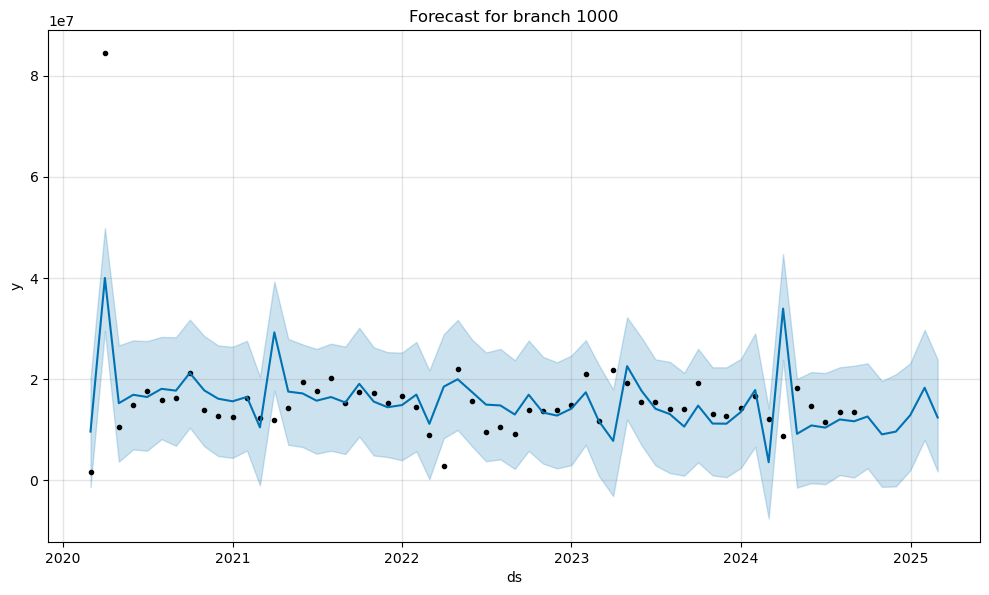

09:28:45 - cmdstanpy - INFO - Chain [1] start processing
09:28:45 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

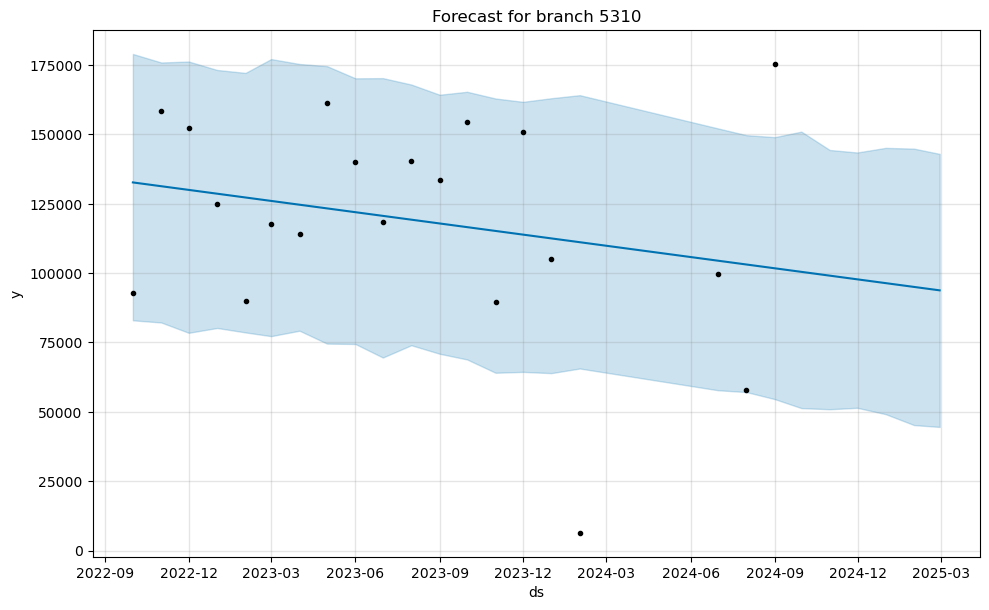

09:28:46 - cmdstanpy - INFO - Chain [1] start processing
09:28:46 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

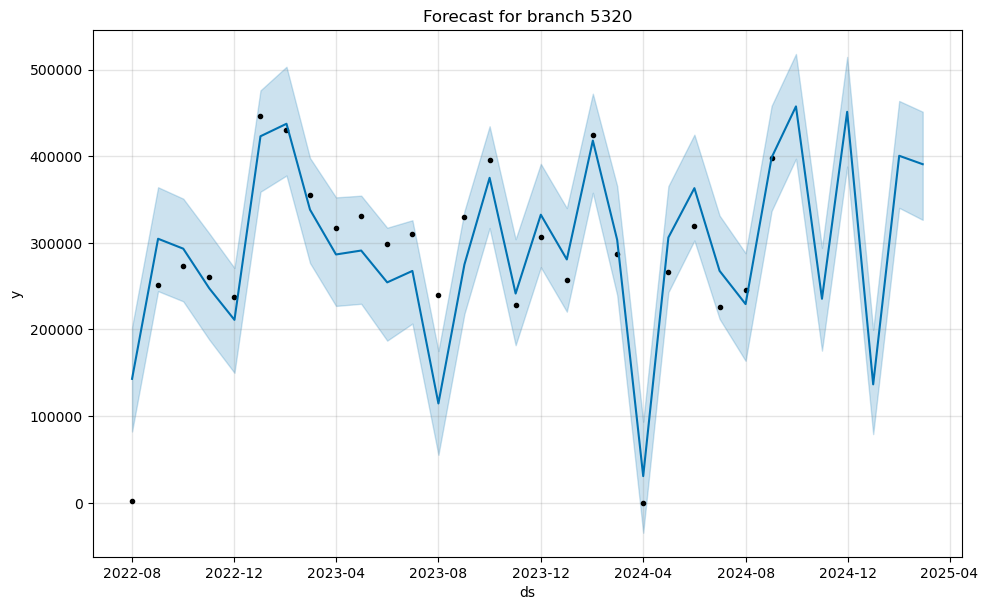

09:28:47 - cmdstanpy - INFO - Chain [1] start processing
09:28:47 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

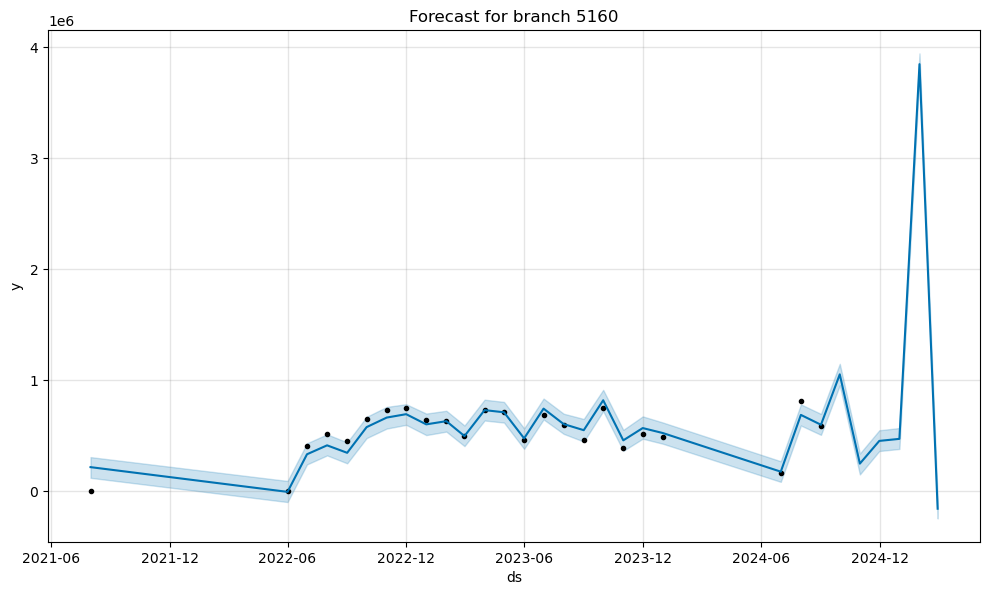

09:28:47 - cmdstanpy - INFO - Chain [1] start processing
09:28:48 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

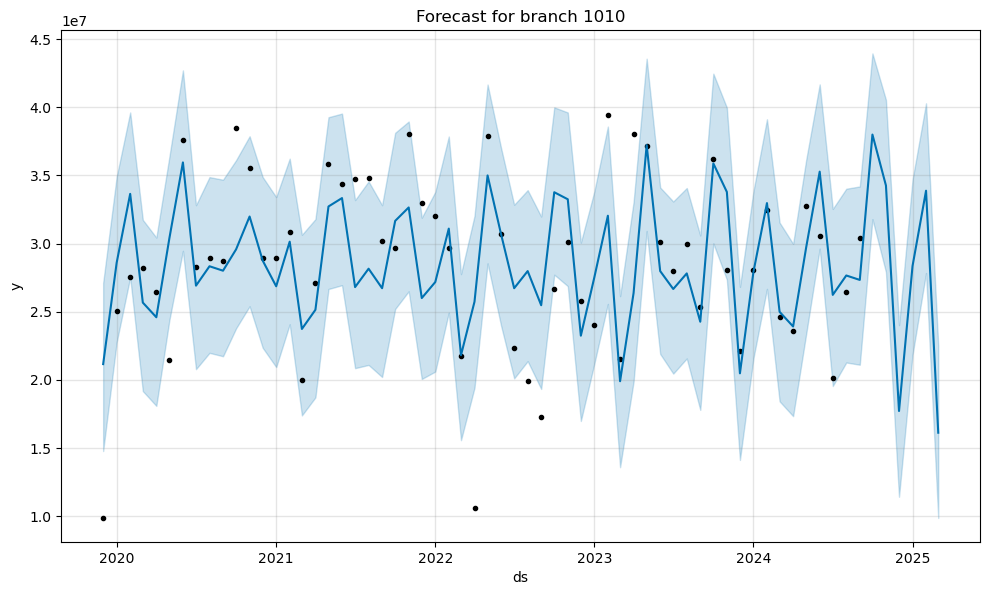

09:28:48 - cmdstanpy - INFO - Chain [1] start processing
09:28:48 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

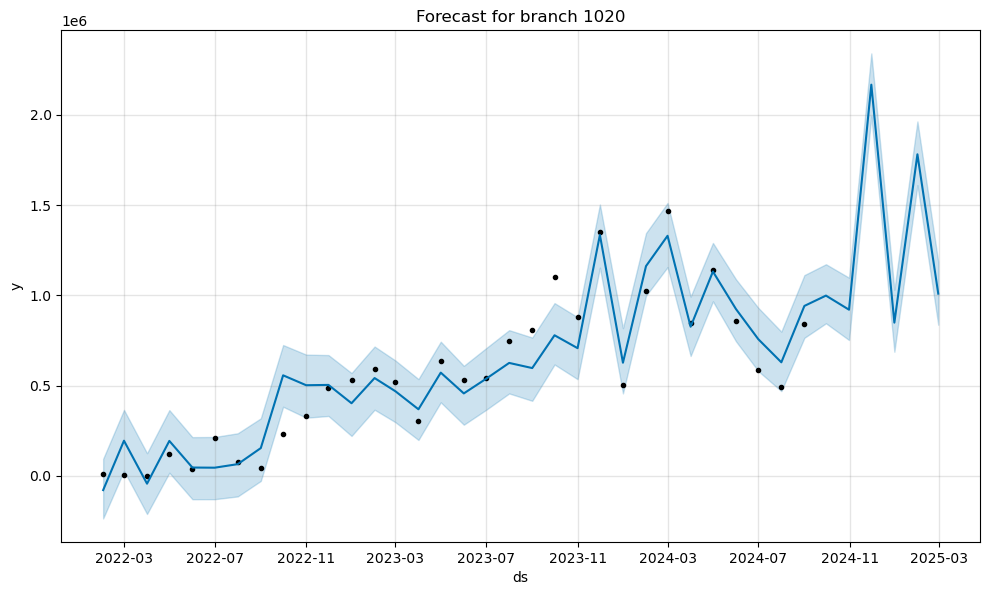

09:28:49 - cmdstanpy - INFO - Chain [1] start processing
09:28:49 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

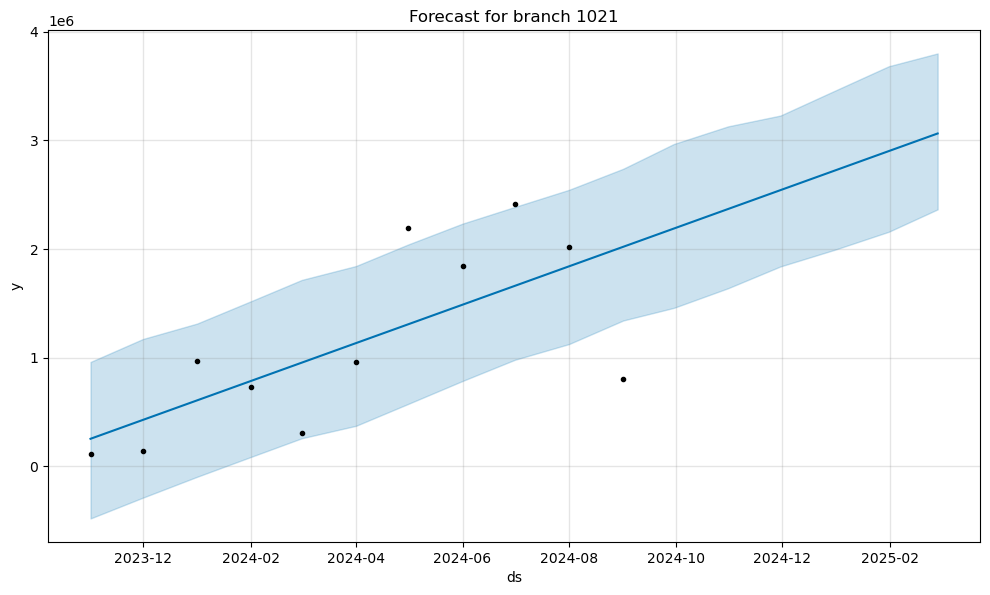

09:28:49 - cmdstanpy - INFO - Chain [1] start processing
09:28:50 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

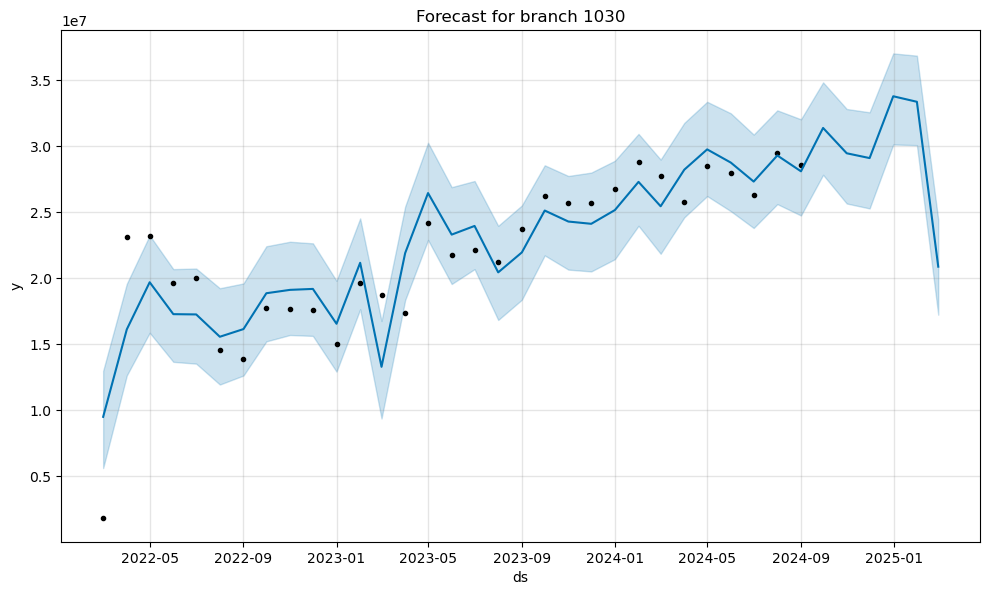

09:28:50 - cmdstanpy - INFO - Chain [1] start processing
09:28:50 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

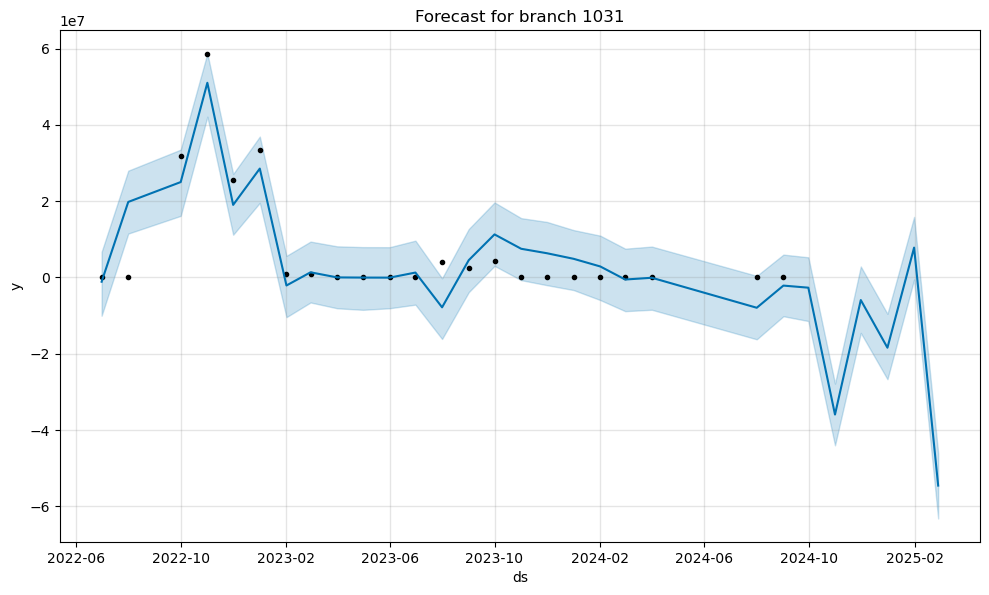

09:28:51 - cmdstanpy - INFO - Chain [1] start processing
09:28:51 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

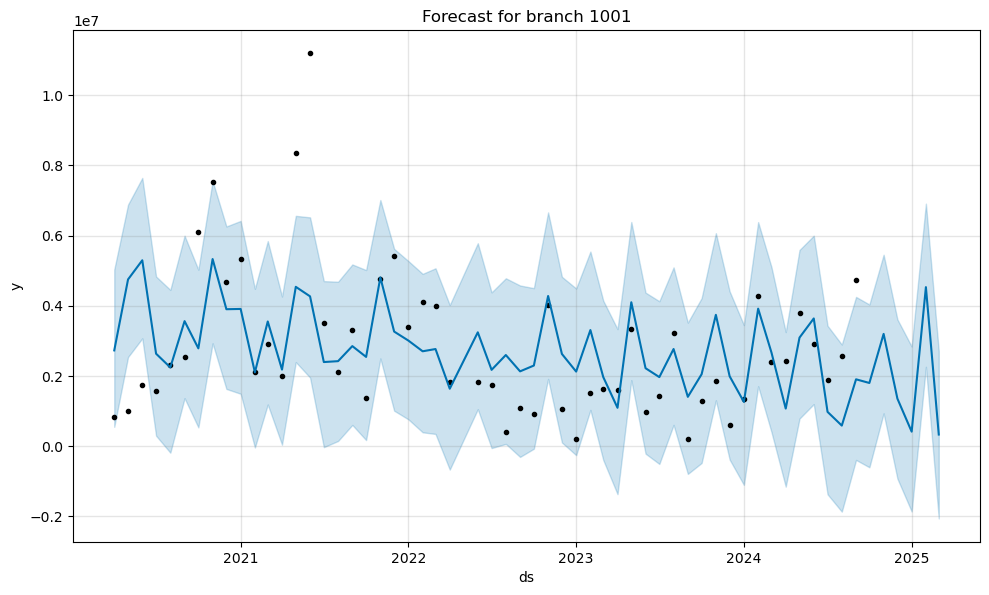

09:28:51 - cmdstanpy - INFO - Chain [1] start processing
09:28:52 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

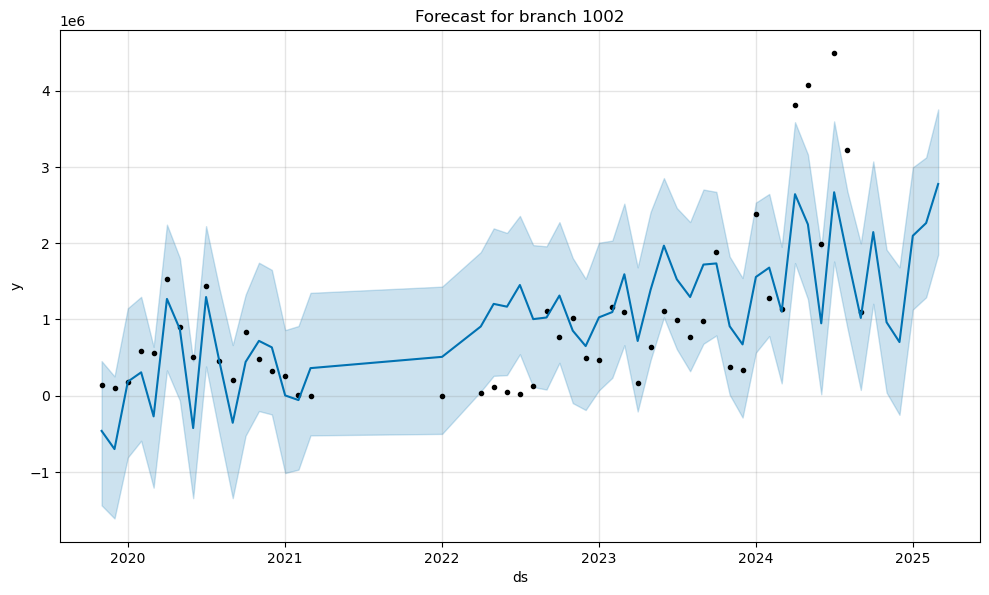

09:28:52 - cmdstanpy - INFO - Chain [1] start processing
09:28:52 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

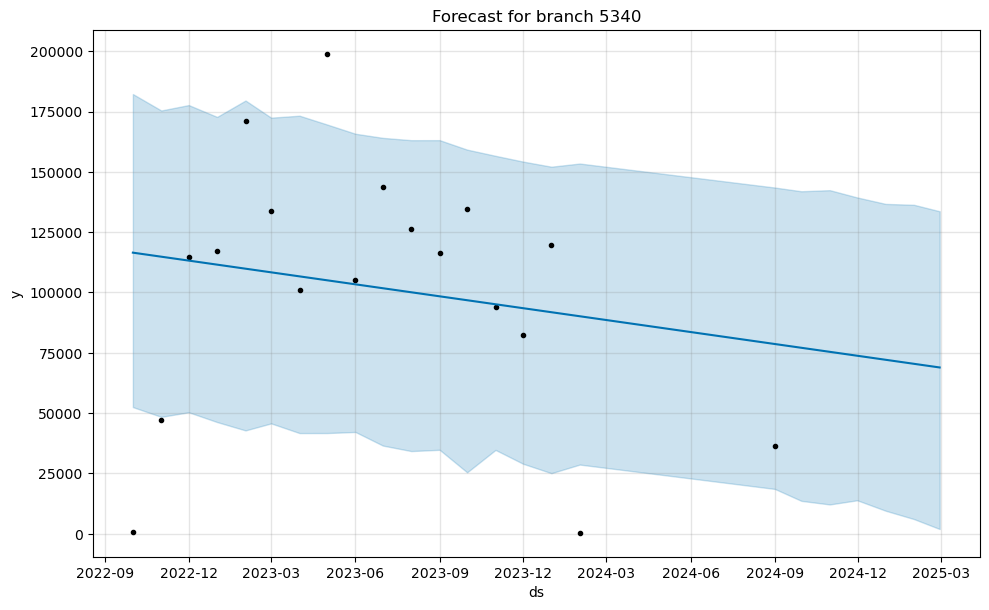

09:28:53 - cmdstanpy - INFO - Chain [1] start processing
09:28:53 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

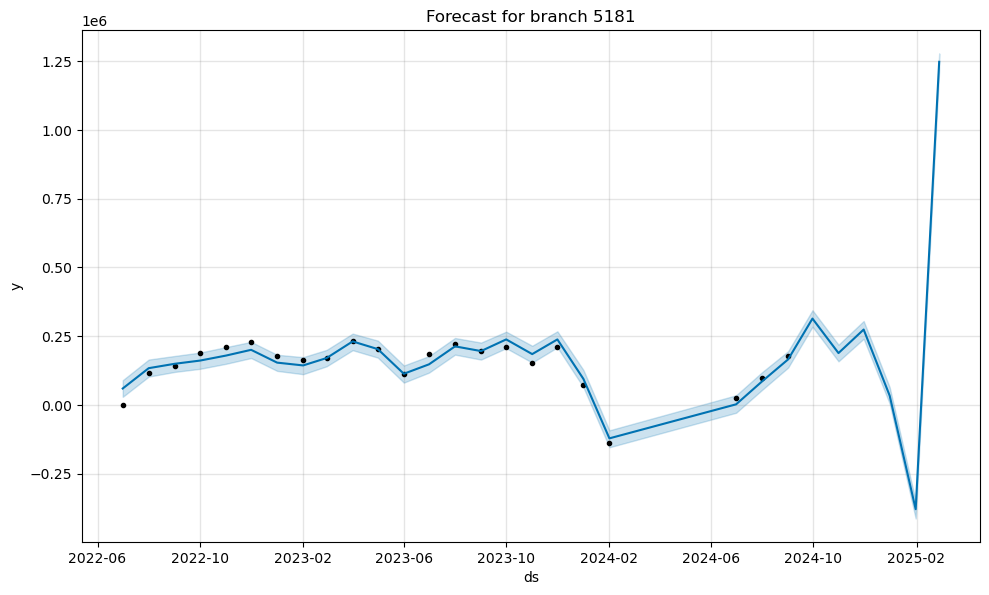

09:28:53 - cmdstanpy - INFO - Chain [1] start processing
09:28:54 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

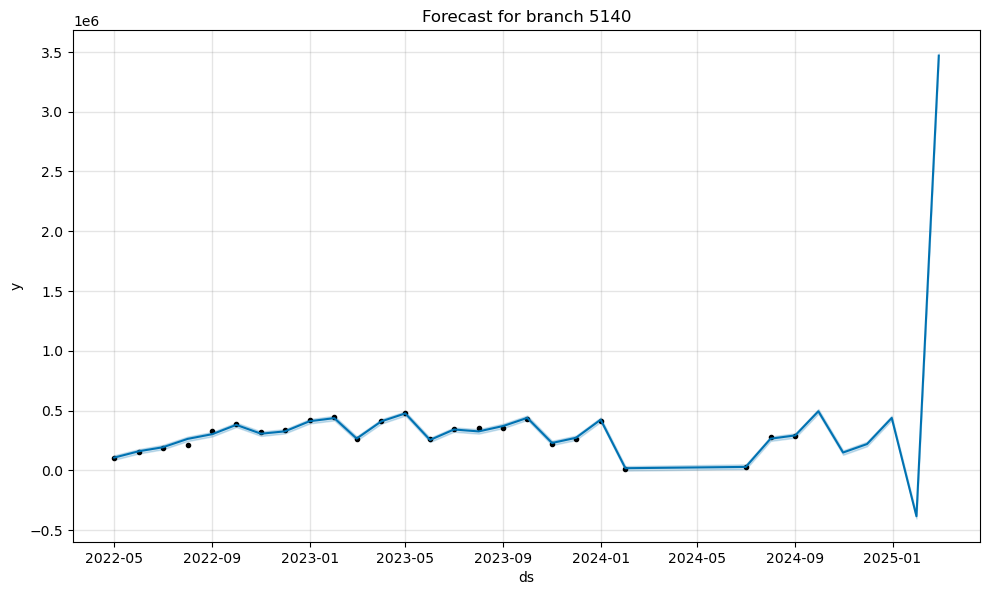

09:28:54 - cmdstanpy - INFO - Chain [1] start processing
09:28:54 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

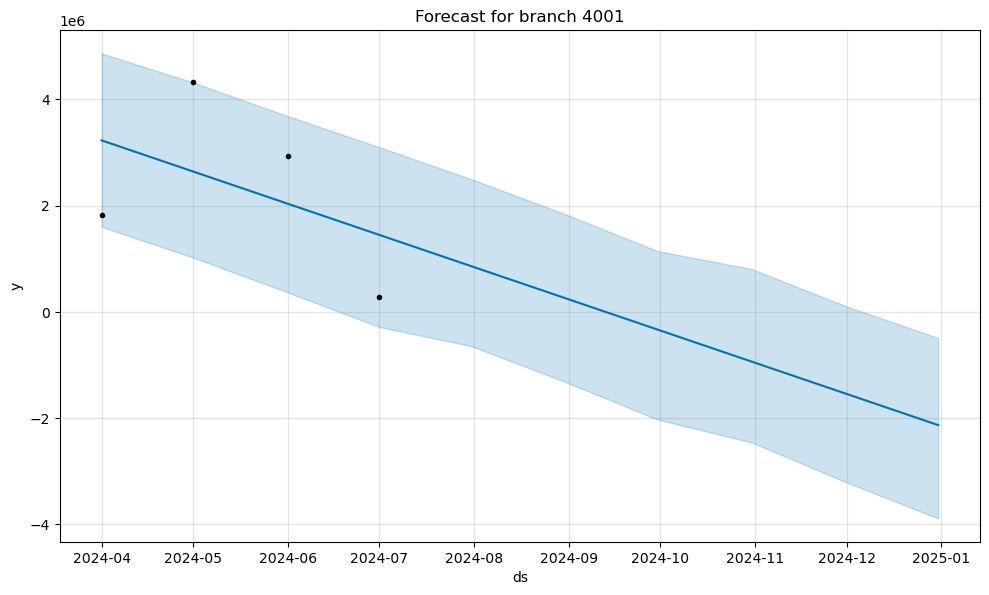

<Figure size 1000x600 with 0 Axes>

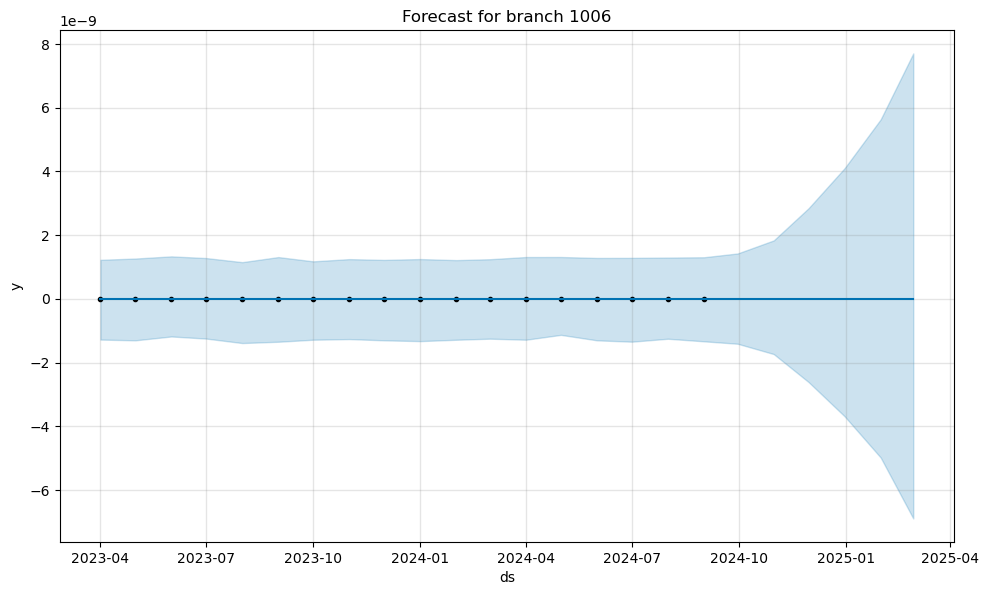

09:28:55 - cmdstanpy - INFO - Chain [1] start processing
09:28:55 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

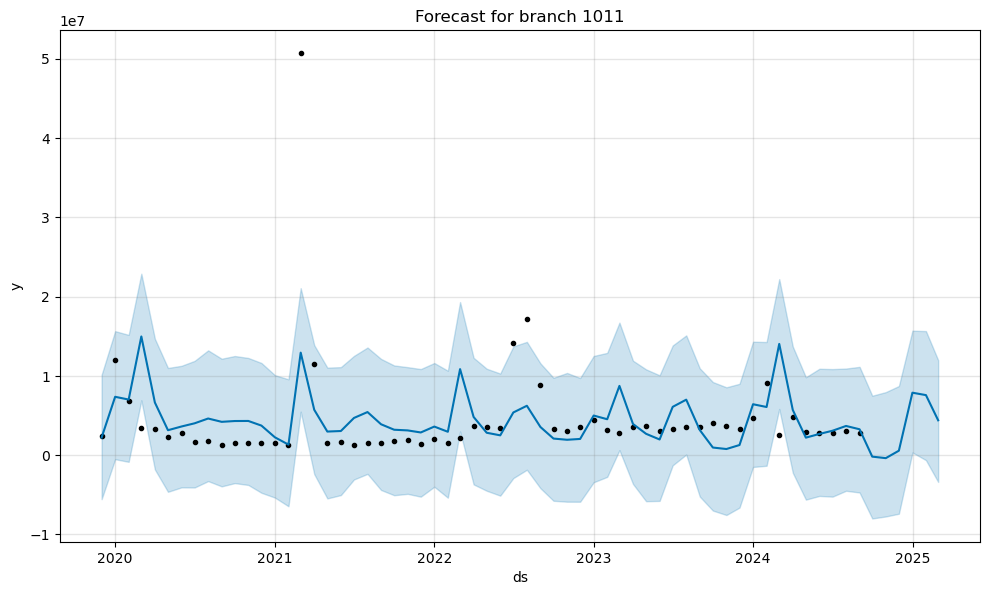

09:28:56 - cmdstanpy - INFO - Chain [1] start processing
09:28:56 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

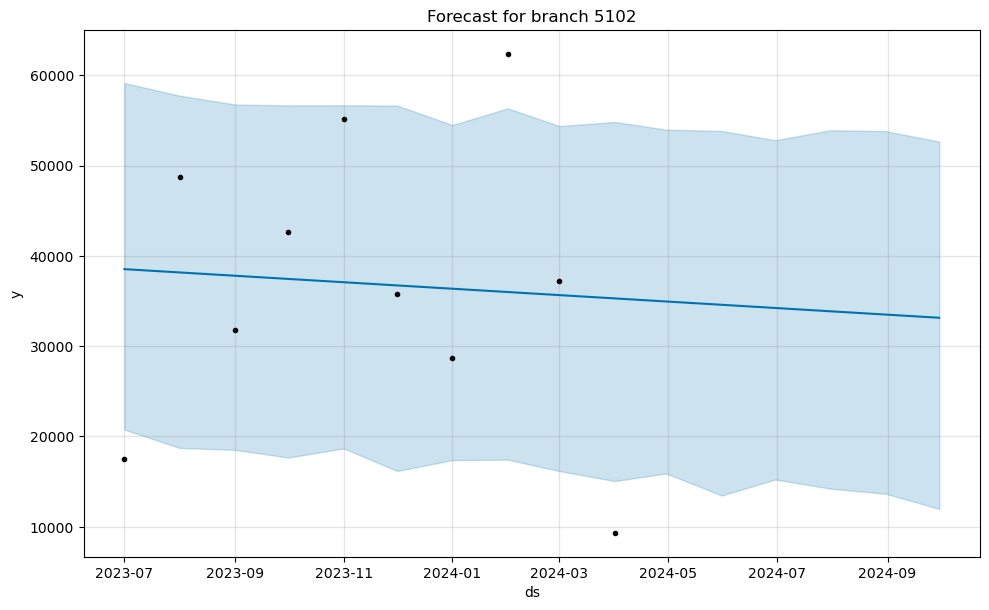

09:28:56 - cmdstanpy - INFO - Chain [1] start processing
09:28:56 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

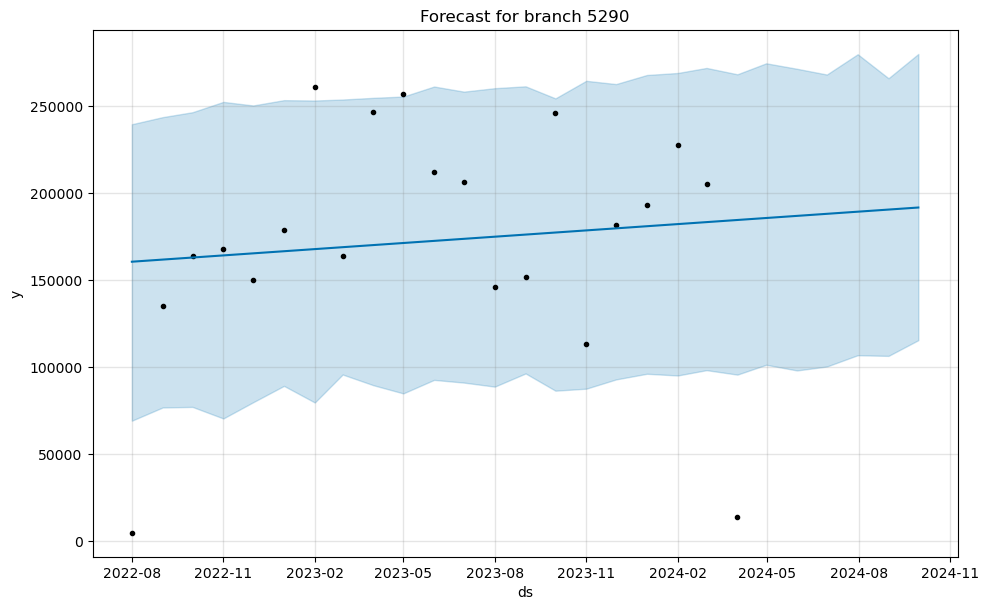

09:28:57 - cmdstanpy - INFO - Chain [1] start processing
09:28:57 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

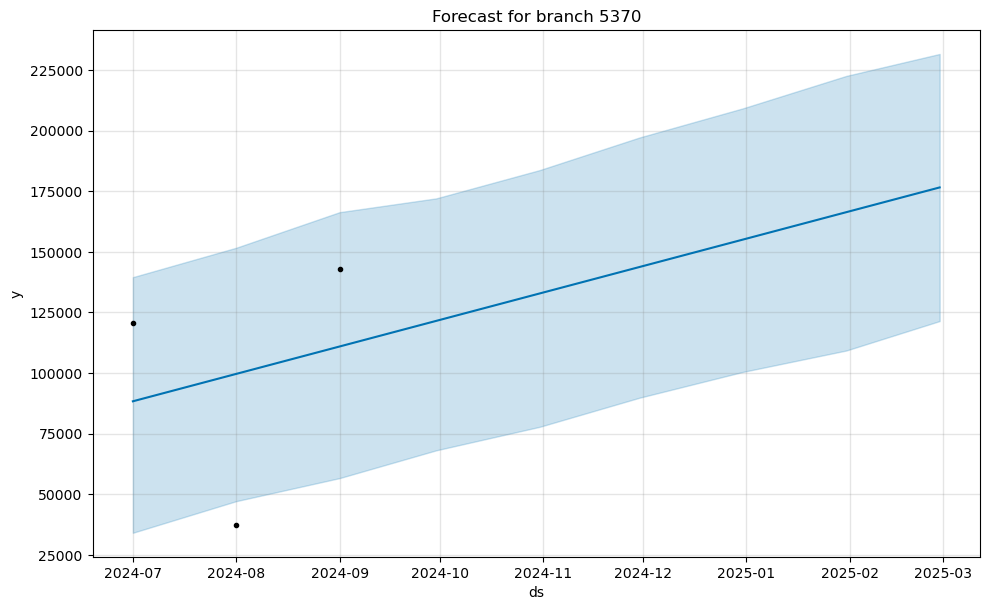

09:28:57 - cmdstanpy - INFO - Chain [1] start processing
09:28:59 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

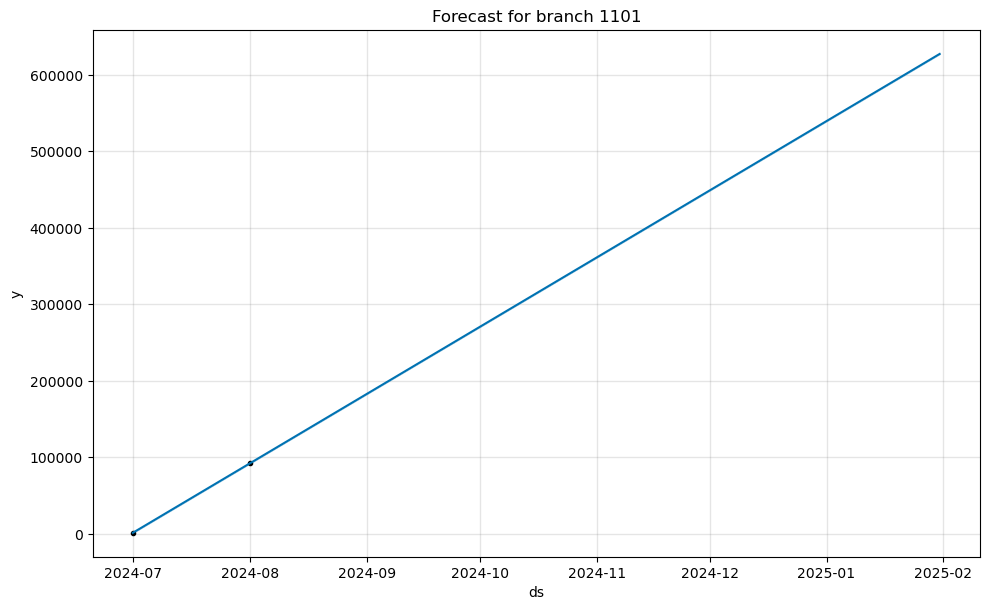

In [17]:


branches = dft['branch'].unique()

for branch in branches:
    branch_data = dft[dft['branch'] == branch][['ds', 'y']]
    
    # ایجاد مدل Prophet
    model = Prophet()
    model.fit(branch_data)
    
    # پیش‌بینی
    future = model.make_future_dataframe( periods=6, freq='M')
    forecast = model.predict(future)
    
    # نتایج پیش‌بینی را برای هر شعبه چاپ کنید
    plt.figure(figsize=(10, 6))
    model.plot(forecast)
    plt.title(f'Forecast for branch {branch}')
    plt.show()


In [18]:
asd[asd['SALEORG']==5010]

DocMonth  SALEORG  AdjustedWeight YearMonth
1390 2024-10-01     5010      1236170.30   2024-10

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# تنظیم اندازه نمودار
plt.figure(figsize=(12, 6))

# تعیین موقعیت میله‌ها
width = 0.35  # عرض هر میله

# رسم نمودار میله‌ای کنار هم برای 'AdjustedWeight'
sns.barplot(x='branch', y='AdjustedWeight', data=zx, color='b', label='AdjustedWeight', ci=None, width=width, position=0)

# رسم نمودار میله‌ای کنار هم برای 'yhat'
sns.barplot(x='branch', y='yhat', data=zx, color='r', label='yhat', ci=None, width=width, position=1)

# تنظیم فاصله بین میله‌ها برای جلوگیری از تداخل
plt.xticks(rotation=45)

# افزودن عنوان و برچسب‌ها
plt.title('Comparison of AdjustedWeight and yhat by Branch')
plt.xlabel('Branch')
plt.ylabel('Value')

# نمایش راهنما (Legend)
plt.legend()

# نمایش نمودار
plt.tight_layout()
plt.show()




NameError: name 'zx' is not defined

<Figure size 1200x600 with 0 Axes>

In [24]:
asd

DocMonth  SALEORG  AdjustedWeight YearMonth
67   2024-10-01     5090        63494.67   2024-10
68   2024-10-01     5160         7988.50   2024-10
98   2024-10-01     1011      3053005.00   2024-10
212  2024-10-01     5120       199716.54   2024-10
252  2024-10-01     1002      3195380.00   2024-10
...         ...      ...             ...       ...
1909 2024-10-01     5110       203293.16   2024-10
1910 2024-10-01     5170       272673.50   2024-10
1911 2024-10-01     5002      2345129.28   2024-10
1912 2024-10-01     5330        46780.00   2024-10
1913 2024-10-01     5150          980.00   2024-10

[38 rows x 4 columns]

In [25]:
import pandas as pd
from prophet import Prophet

branches = dft['branch'].unique()

all_forecasts = []  # لیست برای ذخیره پیش‌بینی‌ها

for branch in branches:
    branch_data = dft[dft['branch'] == branch][['ds', 'y']]
    
    # ایجاد مدل Prophet
    model = Prophet()
    model.fit(branch_data)
    
    # پیش‌بینی برای 6 ماه آینده
    future = model.make_future_dataframe(periods=2, freq='M')
    forecast = model.predict(future)
    
    # اضافه کردن اطلاعات شعبه
    forecast['branch'] = branch
    
    # انتخاب آخرین ماه (بیشترین مقدار `ds`)
    last_month_forecast = forecast.loc[forecast['ds'] == forecast['ds'].max(), ['ds', 'branch', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # ذخیره در لیست
    all_forecasts.append(last_month_forecast)

# ادغام همه داده‌ها در یک DataFrame
forecast_results = pd.concat(all_forecasts, ignore_index=True)

# نمایش خروجی
print(forecast_results.head())

# اگر نیاز به ذخیره در فایل اکسل دارید:
#forecast_results.to_excel('last_month_forecast.xlsx', index=False)



09:29:25 - cmdstanpy - INFO - Chain [1] start processing
09:29:26 - cmdstanpy - INFO - Chain [1] done processing
09:29:26 - cmdstanpy - INFO - Chain [1] start processing
09:29:26 - cmdstanpy - INFO - Chain [1] done processing
09:29:26 - cmdstanpy - INFO - Chain [1] start processing
09:29:27 - cmdstanpy - INFO - Chain [1] done processing
09:29:27 - cmdstanpy - INFO - Chain [1] start processing
09:29:27 - cmdstanpy - INFO - Chain [1] done processing
09:29:27 - cmdstanpy - INFO - Chain [1] start processing
09:29:28 - cmdstanpy - INFO - Chain [1] done processing
09:29:28 - cmdstanpy - INFO - Chain [1] start processing
09:29:28 - cmdstanpy - INFO - Chain [1] done processing
09:29:28 - cmdstanpy - INFO - Chain [1] start processing
09:29:29 - cmdstanpy - INFO - Chain [1] done processing
09:29:29 - cmdstanpy - INFO - Chain [1] start processing
09:29:29 - cmdstanpy - INFO - Chain [1] done processing
09:29:29 - cmdstanpy - INFO - Chain [1] start processing
09:29:29 - cmdstanpy - INFO - Chain [1]

          ds  branch       yhat  yhat_lower  yhat_upper
0 2024-10-31    5070  308871.28   230386.39   378111.21
1 2024-10-31    5020  512838.69   388173.86   644153.08
2 2024-10-31    5010 1669101.66  1265937.33  2095114.15
3 2024-10-31    5100  276374.87   186796.21   363680.39
4 2024-10-31    5050  129072.53    88000.73   170743.13


In [26]:
forecast_results['X']=(forecast_results['yhat_lower']+forecast_results['yhat_upper'])/2

In [27]:
forecast_results

ds  branch       yhat  yhat_lower  yhat_upper          X
0  2024-10-31    5070  308871.28   230386.39   378111.21  304248.80
1  2024-10-31    5020  512838.69   388173.86   644153.08  516163.47
2  2024-10-31    5010 1669101.66  1265937.33  2095114.15 1680525.74
3  2024-10-31    5100  276374.87   186796.21   363680.39  275238.30
4  2024-10-31    5050  129072.53    88000.73   170743.13  129371.93
..        ...     ...        ...         ...         ...        ...
46 2024-10-31    1011 -377860.33 -8885044.99  6954763.77 -965140.61
47 2024-05-31    5102   34585.91    14221.00    53020.21   33620.61
48 2024-05-31    5290  187004.52   104771.35   263850.20  184310.78
49 2024-10-31    5370  132799.64    77890.49   183591.72  130741.11
50 2024-09-30    1101  267537.85   267537.85   267537.86  267537.85

[51 rows x 6 columns]

In [28]:
asd[asd['SALEORG']==5040]

DocMonth  SALEORG  AdjustedWeight YearMonth
1616 2024-10-01     5040       318389.39   2024-10

In [29]:
asd

DocMonth  SALEORG  AdjustedWeight YearMonth
67   2024-10-01     5090        63494.67   2024-10
68   2024-10-01     5160         7988.50   2024-10
98   2024-10-01     1011      3053005.00   2024-10
212  2024-10-01     5120       199716.54   2024-10
252  2024-10-01     1002      3195380.00   2024-10
...         ...      ...             ...       ...
1909 2024-10-01     5110       203293.16   2024-10
1910 2024-10-01     5170       272673.50   2024-10
1911 2024-10-01     5002      2345129.28   2024-10
1912 2024-10-01     5330        46780.00   2024-10
1913 2024-10-01     5150          980.00   2024-10

[38 rows x 4 columns]

In [30]:


# فرض کنیم df_forecast جدول پیش‌بینی باشد
# و df_actual جدول داده‌های واقعی
merged_df = forecast_results.merge(asd, left_on='branch', right_on='SALEORG', how='left')

# نمایش جدول نهایی
print(merged_df.head())


          ds  branch       yhat  yhat_lower  yhat_upper          X   DocMonth  \
0 2024-10-31    5070  308871.28   230386.39   378111.21  304248.80 2024-10-01   
1 2024-10-31    5020  512838.69   388173.86   644153.08  516163.47 2024-10-01   
2 2024-10-31    5010 1669101.66  1265937.33  2095114.15 1680525.74 2024-10-01   
3 2024-10-31    5100  276374.87   186796.21   363680.39  275238.30 2024-10-01   
4 2024-10-31    5050  129072.53    88000.73   170743.13  129371.93 2024-10-01   

   SALEORG  AdjustedWeight YearMonth  
0  5070.00       411135.63   2024-10  
1  5020.00       524222.55   2024-10  
2  5010.00      1236170.30   2024-10  
3  5100.00       312282.95   2024-10  
4  5050.00       210544.73   2024-10  


In [31]:
merged_df=merged_df[merged_df['ds']=='2024-10-31']

In [32]:
merged_df=merged_df[merged_df['branch']!=1031]

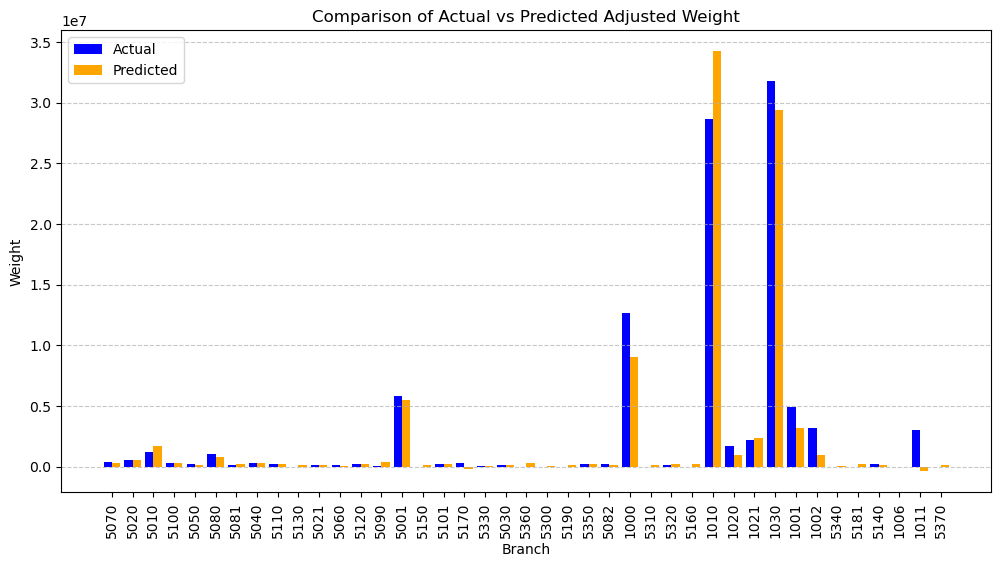

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# نام شعبه‌ها
branches = merged_df['branch'].astype(str)

# مقدار واقعی و پیش‌بینی‌شده
actual_values = merged_df['AdjustedWeight']
predicted_values = merged_df['yhat']

# موقعیت میله‌ها در محور X
x = np.arange(len(branches))

# تنظیم اندازه نمودار
plt.figure(figsize=(12, 6))

# رسم میله‌های مقدار واقعی
plt.bar(x - 0.2, actual_values, width=0.4, label='Actual', color='blue')

# رسم میله‌های مقدار پیش‌بینی‌شده
plt.bar(x + 0.2, predicted_values, width=0.4, label='Predicted', color='orange')

# تنظیمات نمودار
plt.xticks(x, branches, rotation=90)
plt.xlabel('Branch')
plt.ylabel('Weight')
plt.title('Comparison of Actual vs Predicted Adjusted Weight')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# نمایش نمودار
plt.show()
